# Rs(T) vs B

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import warnings
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

In [2]:
def calculate_sheet_resistance_vdp(R_A, R_B, delta=0.0005, max_iterations=10000) -> float:
    # Initial z_i, or z_0
    z_prev = (2 * np.log(2)) / (np.pi * (R_A + R_B))

    iterations = 0
    while iterations < max_iterations:
        # y_i
        # Using 1/exp(x) which is equivalent to exp(-x) for numerical stability
        y_i = np.exp(-np.pi * z_prev * R_A) + np.exp(-np.pi * z_prev * R_B)

        # z_i
        numerator = (1 - y_i) / np.pi
        denominator = (R_A * np.exp(-np.pi * z_prev * R_A) + R_B * np.exp(-np.pi * z_prev * R_B))

        if abs(denominator) < 1e-18: # A small threshold to prevent division by zero
            print(f"Warning: Denominator in z_i calculation is too small. R_A={R_A}, R_B={R_B}. Stopping.")
            return np.nan
        
        z_curr = z_prev - (numerator / denominator)

        # Check for convergence
        if z_curr == 0: # Avoid division by zero if z_curr becomes 0
            if z_prev == 0: # If both are zero, it's converged to zero
                break
            else: # If z_curr is zero but z_prev isn't, the relative change is infinite
                # This indicates a potential issue or Rs becoming infinitely large, meaning bad R_A, R_B
                print(f"Warning: z_curr became 0. R_A={R_A}, R_B={R_B}. Stopping.")
                return np.nan

        relative_change = abs((z_curr - z_prev) / z_curr)

        if relative_change < delta:
            R_s = 1 / z_curr
            return R_s

        z_prev = z_curr
        iterations += 1

    print(f"Warning: Calculation did not converge within {max_iterations} iterations for R_A={R_A}, R_B={R_B}.")
    return np.nan

Read the data

In [3]:
# --- Parameters ---
#data_dir = "C:/Users/fzana/OneDrive/Desktop/quantum engineering/Advanced experimental physics/Nb-Characterization/SUPERCONDUCTIVITY/DataSets"  # Change to your directory if needed
data_dir = "./DataSets/"
file_pattern = os.path.join(data_dir, "2025-04-08_VdP_B*T.dat")
intra_cutoff = 0       
inter_cutoff = 0       

# --- Column indices (0-based) ---
columns_to_read = [5, 6, 7, 16, 17, 18]  # front_temp, front_temp_fluct, front_R, back_temp, back_temp_fluct, back_R

# --- Store results ---
raw_data = {}
filtered_data = {}

# --- Loop over all files ---
for filepath in sorted(glob.glob(file_pattern)):
    # Extract the x value from the filename
    basename = os.path.basename(filepath)
    try:
        x_str = basename.split("B")[-1].split("T.dat")[0]
        x_key = x_str.replace('.', '_')  # For variable safety
        x_val = float(x_str)
    except Exception as e:
        print(f"Skipping file {basename} due to parsing error: {e}")
        continue

    # Load the required columns only
    try:
        data = pd.read_csv(filepath, sep=r'\s+', header=None, usecols=columns_to_read)
        data.columns = ['front_temp', 'front_temp_fluct', 'front_R', 'back_temp', 'back_temp_fluct', 'back_R']
    except Exception as e:
        print(f"Error reading {basename}: {e}")
        continue

    # Store raw values
    for col in data.columns:
        raw_data[f"{col}_raw_{x_str}"] = data[col].copy()

    # Compute average temperature
    #avg_temp = (data['front_temp'] + data['back_temp']) / 2

    # Mask
    sel_mask = (
        (data['front_R'] > 0) & (data['back_R'] > 0) &
        (data['front_temp_fluct'] <= intra_cutoff) &
        (data['back_temp_fluct'] <= intra_cutoff) &
        (abs(data['front_temp'] - data['back_temp']) == inter_cutoff)
    )

    # Apply mask and store filtered values
    filtered_data[f"Rf_{x_str}"] = data['front_R'][sel_mask].values
    filtered_data[f"Rb_{x_str}"] = data['back_R'][sel_mask].values
    #filtered_data[f"Tavg_{x_str}"] = avg_temp[sel_mask].values
    filtered_data[f"Tf_{x_str}"] = data['front_temp'][sel_mask].values
    filtered_data[f"Tb_{x_str}"] = data['back_temp'][sel_mask].values

print("Processing complete. Variables are stored in raw_data and filtered_data dictionaries.")
print(filtered_data.keys())

Skipping file 2025-04-08_VdP_B_from_0.4_to_0T.dat due to parsing error: could not convert string to float: '_from_0.4_to_0'
Processing complete. Variables are stored in raw_data and filtered_data dictionaries.
dict_keys(['Rf_0.4', 'Rb_0.4', 'Tf_0.4', 'Tb_0.4', 'Rf_0.8', 'Rb_0.8', 'Tf_0.8', 'Tb_0.8', 'Rf_0', 'Rb_0', 'Tf_0', 'Tb_0', 'Rf_1.6', 'Rb_1.6', 'Tf_1.6', 'Tb_1.6', 'Rf_2.4', 'Rb_2.4', 'Tf_2.4', 'Tb_2.4', 'Rf_3.2', 'Rb_3.2', 'Tf_3.2', 'Tb_3.2', 'Rf_3.6', 'Rb_3.6', 'Tf_3.6', 'Tb_3.6', 'Rf_3.8', 'Rb_3.8', 'Tf_3.8', 'Tb_3.8', 'Rf_4.0', 'Rb_4.0', 'Tf_4.0', 'Tb_4.0'])


In [4]:
# --- Compute and store sheet resistance Rs for each x ---
for key in list(filtered_data.keys()):
    if key.startswith("Rf_"):
        x_str = key.split("_")[1]

        Rf_vals = filtered_data[f"Rf_{x_str}"]
        Rb_vals = filtered_data[f"Rb_{x_str}"]

        if len(Rf_vals) != len(Rb_vals):
            print(f"Length mismatch for x = {x_str}. Skipping Rs computation.")
            continue

        # Calculate sheet resistance for each pair
        Rs_vals = np.array([
            calculate_sheet_resistance_vdp(R_A, R_B)
            for R_A, R_B in zip(Rf_vals, Rb_vals)
        ])

        filtered_data[f"Rs_{x_str}"] = Rs_vals

print(filtered_data.keys())


dict_keys(['Rf_0.4', 'Rb_0.4', 'Tf_0.4', 'Tb_0.4', 'Rf_0.8', 'Rb_0.8', 'Tf_0.8', 'Tb_0.8', 'Rf_0', 'Rb_0', 'Tf_0', 'Tb_0', 'Rf_1.6', 'Rb_1.6', 'Tf_1.6', 'Tb_1.6', 'Rf_2.4', 'Rb_2.4', 'Tf_2.4', 'Tb_2.4', 'Rf_3.2', 'Rb_3.2', 'Tf_3.2', 'Tb_3.2', 'Rf_3.6', 'Rb_3.6', 'Tf_3.6', 'Tb_3.6', 'Rf_3.8', 'Rb_3.8', 'Tf_3.8', 'Tb_3.8', 'Rf_4.0', 'Rb_4.0', 'Tf_4.0', 'Tb_4.0', 'Rs_0.4', 'Rs_0.8', 'Rs_0', 'Rs_1.6', 'Rs_2.4', 'Rs_3.2', 'Rs_3.6', 'Rs_3.8', 'Rs_4.0'])


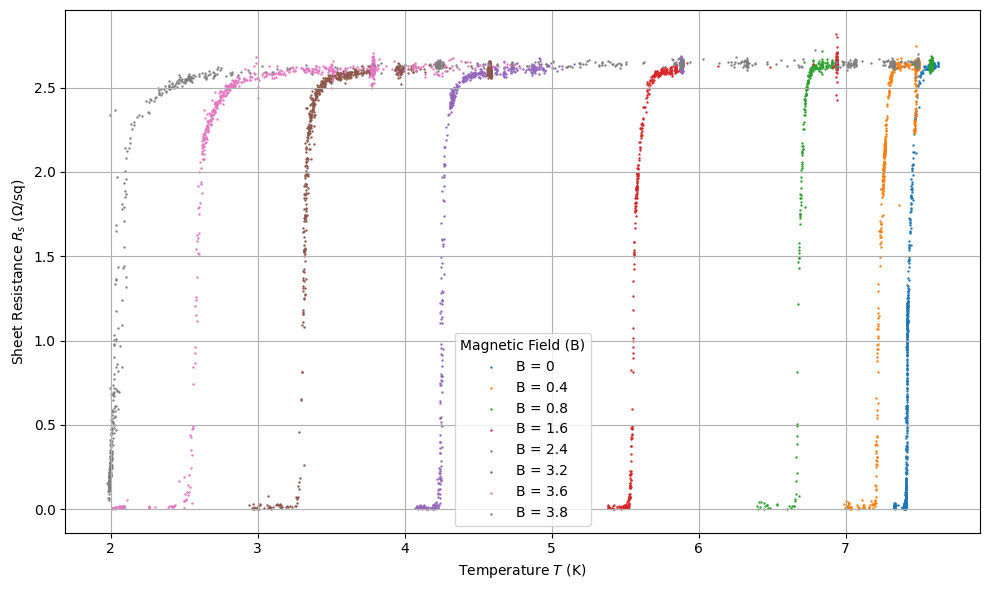

In [5]:
# --- Plot all Rs_x vs Tf_x as scatter plots in one figure ---
plt.figure(figsize=(10, 6))

for key in sorted(filtered_data.keys()):
    if key.startswith("Rs_"):
        x_str = key.split("_")[1]

        if x_str == '4.0':
            continue

        Rs_vals = filtered_data[key]
        Tf_key = f"Tf_{x_str}"

        # Check if Tf_x exists
        if Tf_key not in filtered_data:
            print(f"Missing {Tf_key} for plotting Rs_{x_str}, skipping.")
            continue

        Tf_vals = filtered_data[Tf_key]

        if len(Rs_vals) != len(Tf_vals):
            print(f"Length mismatch for Rs_{x_str} and Tf_{x_str}, skipping.")
            continue

        # # Sort values for cleaner plotting
        # sorted_indices = np.argsort(Tf_vals)
        # Tf_sorted = Tf_vals[sorted_indices]
        # Rs_sorted = Rs_vals[sorted_indices]

        # Scatter plot
        plt.scatter(Tf_vals, Rs_vals, label=f"B = {x_str}", s=.5)

# Plot formatting
plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Sheet Resistance $R_s$ (Ω/sq)")
#plt.title("Sheet Resistance vs Temperature")
plt.legend(title="Magnetic Field (B)")
plt.grid(True)
plt.tight_layout()
plt.show()

# **$T_C$ Evaluation**

## **50-90-10 RAW Method**

### $T_C$

<>:93: SyntaxWarning: invalid escape sequence '\p'
<>:93: SyntaxWarning: invalid escape sequence '\p'
C:\Users\feder\AppData\Local\Temp\ipykernel_27280\4118212024.py:93: SyntaxWarning: invalid escape sequence '\p'
  ax_r.text(0.9, 0.58, f'$T_c = {Tc:.2f} \pm {uncertainty:.2f} K$',


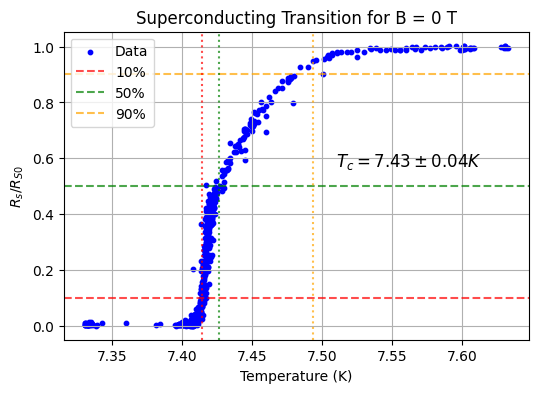

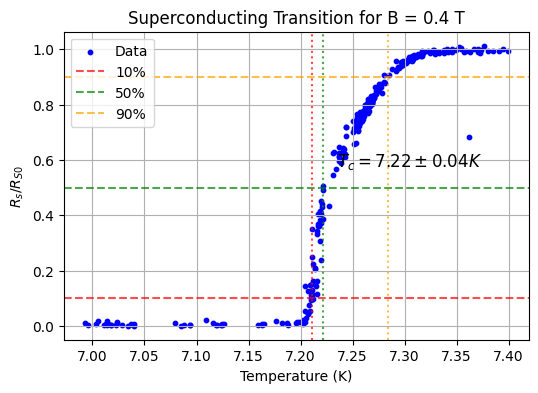

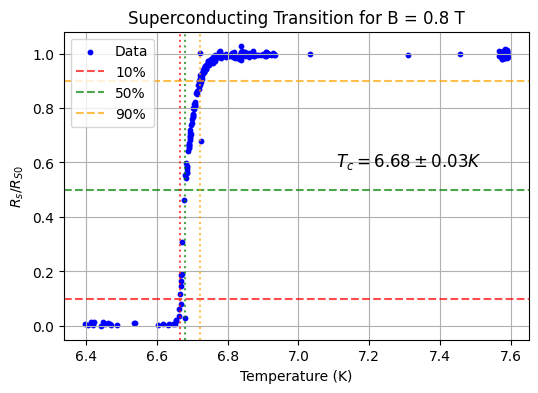

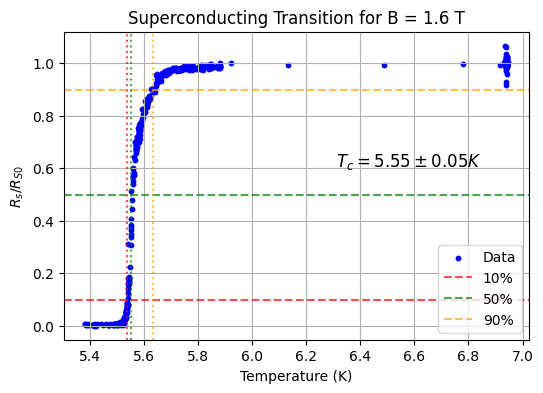

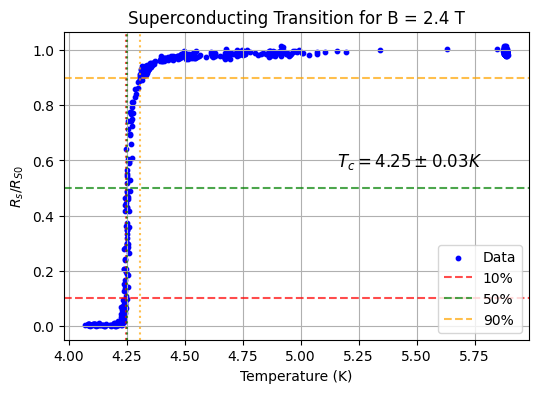

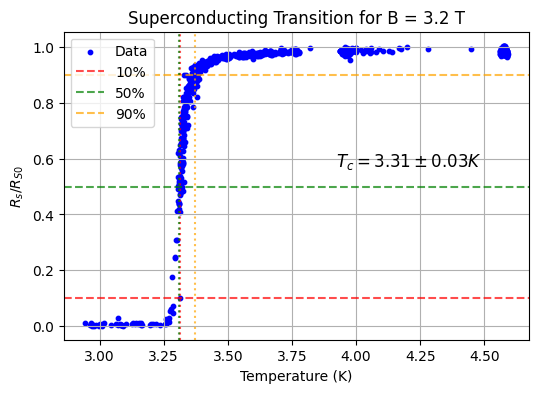

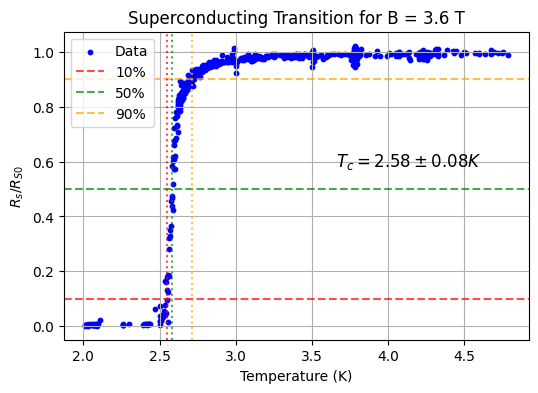

Critical Temperatures: [array(7.42585666), array(7.22146758), array(6.67893477), array(5.55421816), array(4.25070943), array(3.30845614), array(2.5841235)]
Uncertainties: [0.0396712193668316, 0.03666391434780003, 0.026997290645912386, 0.046845899337540686, 0.029808158435620236, 0.030608197574264695, 0.08038448892985262]


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- X values from your original dataset names ---
B_vals = [0, 0.4, 0.8, 1.6, 2.4, 3.2, 3.6]
Tc_vals = []
Tc_uncertainties = []
Rs_0 = 2.64270235
Rs_0_uncertainty = 0.4624039

threshold_10 = 0.1
threshold_50 = 0.5
threshold_90 = 0.9

# Assuming 'filtered_data' is a dictionary or a similar structure
# For example:
# filtered_data = {
#     'Tf_0': np.linspace(8, 10, 50),
#     'Rs_0': np.linspace(0.1, 3.0, 50),
#     'Tf_0.4': np.linspace(7, 9.5, 50),
#     'Rs_0.4': np.linspace(0.1, 3.0, 50),
#     'Tf_0.8': np.linspace(6, 8.5, 50),
#     'Rs_0.8': np.linspace(0.1, 3.0, 50),
#     'Tf_1.6': np.linspace(5, 7.5, 50),
#     'Rs_1.6': np.linspace(0.1, 3.0, 50),
#     'Tf_2.4': np.linspace(4, 6.5, 50),
#     'Rs_2.4': np.linspace(0.1, 3.0, 50),
#     'Tf_3.2': np.linspace(3, 5.5, 50),
#     'Rs_3.2': np.linspace(0.1, 3.0, 50),
#     'Tf_3.6': np.linspace(2, 4.5, 50),
#     'Rs_3.6': np.linspace(0.1, 3.0, 50),
# }

for x in B_vals:
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]

    sorted_indices = np.argsort(Tf)
    Tf = Tf[sorted_indices]
    Rs = Rs[sorted_indices]

    R_norm = Rs / Rs_0

    interp_func = interp1d(R_norm, Tf, kind='linear',
                            bounds_error=False, fill_value='extrapolate')

    T_10 = interp_func(threshold_10)
    T_50 = interp_func(threshold_50)
    T_90 = interp_func(threshold_90)

    if np.isnan(T_10) or np.isnan(T_50) or np.isnan(T_90):
        print(f"Warning: Interpolation failed for B = {x}")

    Tc = T_50
    uncertainty = (T_90 - T_10) / 2

    result = {
        'Tc': Tc,
        'uncertainty': uncertainty,
        'T_10': T_10,
        'T_50': T_50,
        'T_90': T_90,
        'Rs_0': Rs_0,
        'B_field': x
    }

    Tc_vals.append(result['Tc'])
    Tc_uncertainties.append(result['uncertainty'])


    # Create a new figure for each plot
    fig, ax_r = plt.subplots(figsize=(6, 4))

    ax_r.scatter(Tf, R_norm, color='blue', s=10, label="Data")
    ax_r.axhline(y=threshold_10, color='r', linestyle='--', alpha=0.7, label='10%')
    ax_r.axhline(y=threshold_50, color='g', linestyle='--', alpha=0.7, label='50%')
    ax_r.axhline(y=threshold_90, color='orange', linestyle='--', alpha=0.7, label='90%')
    ax_r.axvline(x=T_10, color='r', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_50, color='g', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_90, color='orange', linestyle=':', alpha=0.7)

    ax_r.text(0.9, 0.58, f'$T_c = {Tc:.2f} \pm {uncertainty:.2f} K$',
              transform=ax_r.transAxes, ha='right', va='center', fontsize=12)

    ax_r.set_ylabel("$R_s/R_{S0}$")
    ax_r.set_xlabel("Temperature (K)")
    ax_r.set_title(f"Superconducting Transition for B = {x} T")
    ax_r.legend()
    ax_r.grid(True)

    # Display the current figure
    plt.show()

print("Critical Temperatures:", Tc_vals)
print("Uncertainties:", Tc_uncertainties)


### $T_{zero}$ and $T_{on}$

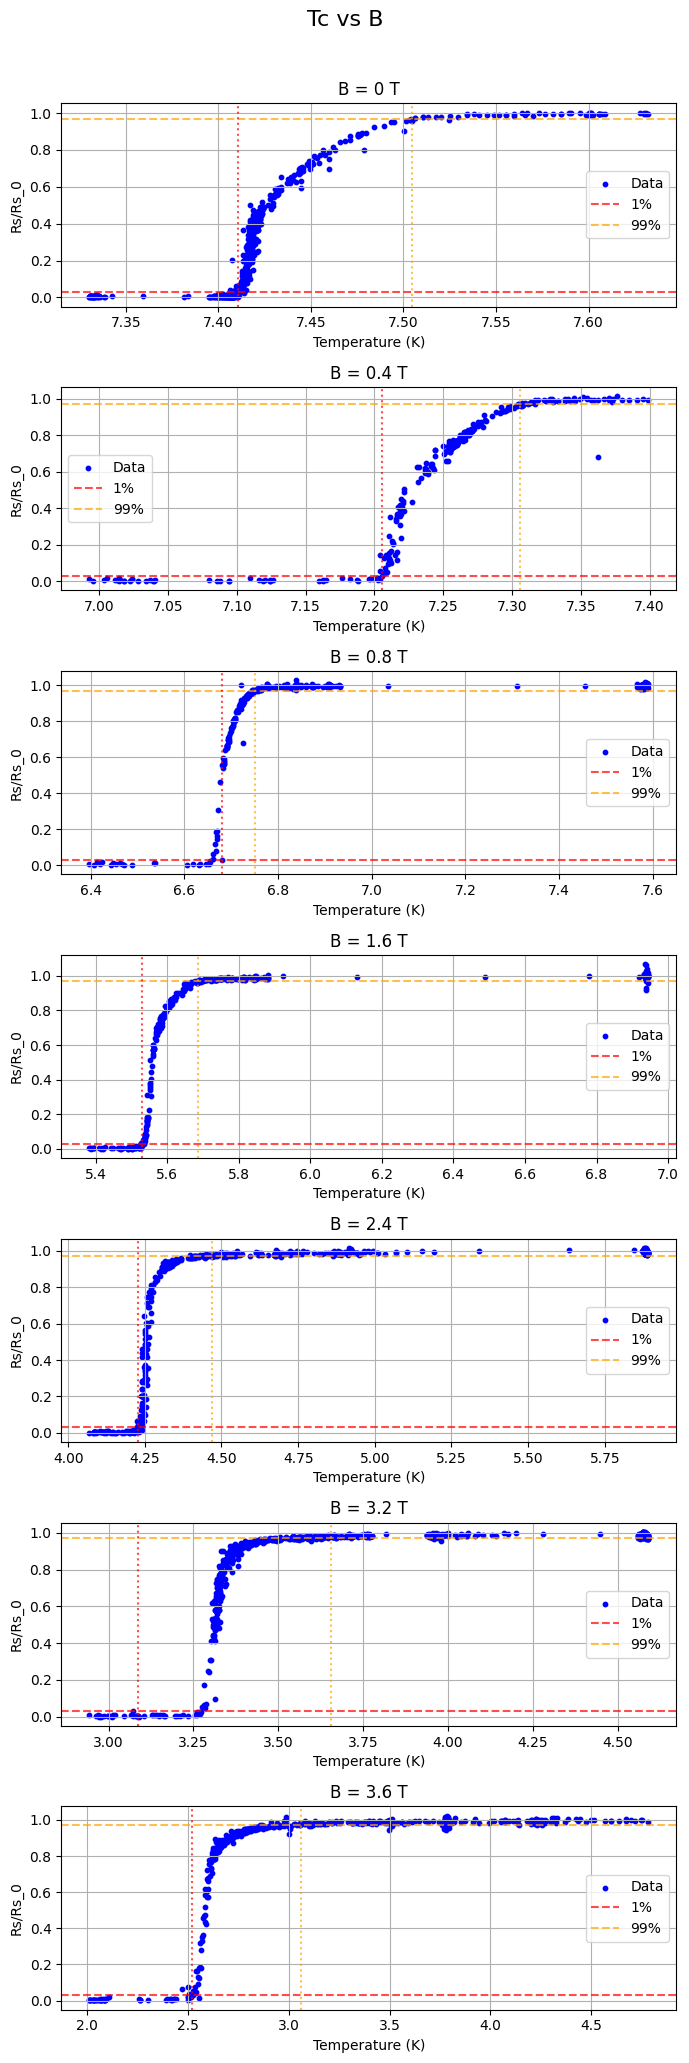

[array(7.41046988), array(7.20545385), array(6.6793707), array(5.53045845), array(4.22682466), array(3.08722373), array(2.52060104)]
[array(7.50485628), array(7.30573587), array(6.75047799), array(5.68632703), array(4.46959052), array(3.65555419), array(3.06155572)]


In [7]:
# --- X values from your original dataset names ---
B_vals = [0, 0.4, 0.8, 1.6, 2.4, 3.2, 3.6]
Tzero_vals = []
Ton_vals = []
Rs_0 = 2.64270235
Rs_0_uncertainty = 0.4624039

threshold_zero = 0.03  
threshold_on = 0.97

# --- Plotting ---
fig, axs = plt.subplots(len(B_vals), 1, figsize=(7, 3 * len(B_vals)), sharex=False)
fig.suptitle("Tc vs B", fontsize=16)

for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]

    R_norm = Rs / Rs_0

    interp_func = interp1d(R_norm, Tf, kind='linear',
                          bounds_error=False, fill_value='extrapolate')
    
    T_zero = interp_func(threshold_zero)
    T_on = interp_func(threshold_on)

    if np.isnan(T_zero) or np.isnan(T_on):
        print(f"Warning: Interpolation failed for B = {x}")

    result = {
        'uncertainty': uncertainty,
        'T_zero': T_zero,
        'T_on': T_on,
        'Rs_0': Rs_0,
        'B_field': x
    }

    Tzero_vals.append(result['T_zero'])
    Ton_vals.append(result['T_on'])

    # --- Plot Rs(T) ---
    ax_r = axs[i]
    ax_r.scatter(Tf, R_norm, color='blue', s=10, label="Data")
    ax_r.axhline(y=threshold_zero, color='r', linestyle='--', alpha=0.7, label='1%')
    ax_r.axhline(y=threshold_on, color='orange', linestyle='--', alpha=0.7, label='99%')
    ax_r.axvline(x=T_zero, color='r', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_on, color='orange', linestyle=':', alpha=0.7)
    ax_r.set_ylabel("Rs/Rs_0")
    ax_r.set_xlabel("Temperature (K)")
    ax_r.set_title(f"B = {x} T")
    ax_r.legend()
    ax_r.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print(Tzero_vals)
print(Ton_vals)

### Phase Diagram

Initial guesses for fit: Bc2(0)=5.40, Tc_MF=7.43

Fitted EGL Parameters:
  Bc2(0) = 4.5530 +/- 0.0405 T
  Tc^MF  = 7.8157 +/- 0.0359 K


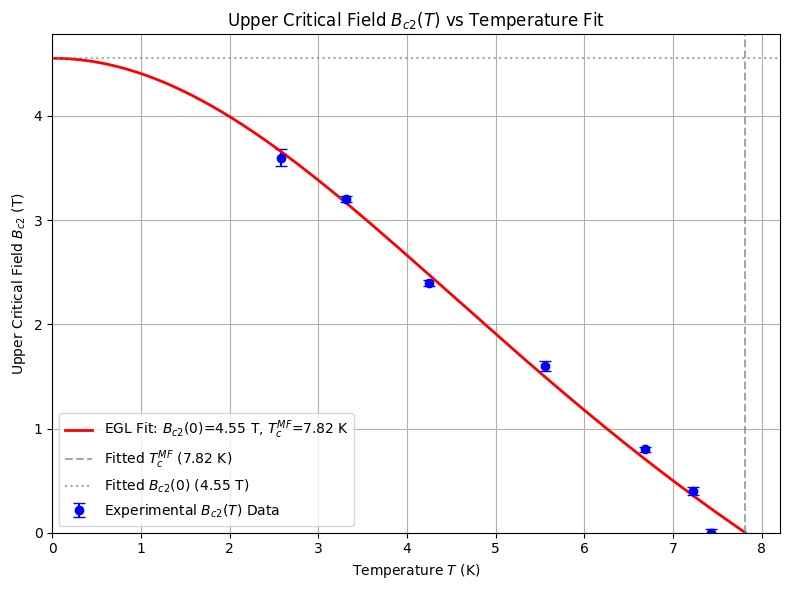

In [8]:
# --- Define the Extended Ginzburg-Landau (EGL) function to fit ---
def egl_model(T, Bc2_0, Tc_MF):
    # Ensure T is not exactly Tc_MF to avoid division by zero in t^2/1+t^2
    # Also handle cases where T > Tc_MF as Bc2 should be 0 there.
    T_non_zero_check = np.where(T >= Tc_MF, Tc_MF - 1e-9, T) # Small offset for T near Tc_MF

    t = T_non_zero_check / Tc_MF

    result = np.where(t < 1, Bc2_0 * (1 - t**2) / (1 + t**2), 0.0)
    
    return result

# 1. Bc2_0:
#    A good guess is the highest B_val.
initial_Bc2_0_guess = np.max(B_vals) * 1.5 # Guess it's a bit higher than max measured B
# 2. Tc_MF:
#    A good guess is the Tc(B=0.4).
initial_Tc_MF_guess = Tc_vals[np.argmin(B_vals)]

initial_guess = [initial_Bc2_0_guess, initial_Tc_MF_guess]

print(f"Initial guesses for fit: Bc2(0)={initial_Bc2_0_guess:.2f}, Tc_MF={initial_Tc_MF_guess:.2f}")

# --- Perform the Curve Fit ---
try:
    popt, pcov = curve_fit(egl_model, Tc_vals, B_vals, p0=initial_guess, sigma=Tc_uncertainties, absolute_sigma=True)

    Bc2_0_fit, Tc_MF_fit = popt
    
    # Calculate standard errors of the fitted parameters
    perr = np.sqrt(np.diag(pcov))
    Bc2_0_err, Tc_MF_err = perr

    print(f"\nFitted EGL Parameters:")
    print(f"  Bc2(0) = {Bc2_0_fit:.4f} +/- {Bc2_0_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_fit:.4f} +/- {Tc_MF_err:.4f} K")

    # --- Generate the Fitted Curve for Plotting ---
    # Create a fine grid of temperatures from 0 up to Tc_MF
    T_fit_curve = np.linspace(0, Tc_MF_fit, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, Bc2_0_fit, Tc_MF_fit)

except RuntimeError as e:
    print(f"Error: Could not fit the EGL model. {e}")
    Bc2_0_fit, Tc_MF_fit = initial_guess # Use initial guess for plotting if fit fails
    T_fit_curve = np.linspace(0, initial_Tc_MF_guess * 1.1, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, initial_Bc2_0_guess, initial_Tc_MF_guess)
    perr = [np.nan, np.nan] # Indicate errors are not available

# --- Plotting the Data and Fit ---
plt.figure(figsize=(8, 6))

# Plot experimental data with error bars
plt.errorbar(Tc_vals, B_vals, yerr=Tc_uncertainties, fmt='o', color='blue', capsize=4, label="Experimental $B_{c2}(T)$ Data")

# Plot the fitted EGL curve
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='-', linewidth=2,
         label=f"EGL Fit: $B_{{c2}}(0)$={Bc2_0_fit:.2f} T, $T_c^{{MF}}$={Tc_MF_fit:.2f} K")

# Add a dashed line for the fitted Tc_MF
plt.axvline(x=Tc_MF_fit, color='gray', linestyle='--', alpha=0.7, label=f"Fitted $T_c^{{MF}}$ ({Tc_MF_fit:.2f} K)")
plt.axhline(y=Bc2_0_fit, color='gray', linestyle=':', alpha=0.7, label=f"Fitted $B_{{c2}}(0)$ ({Bc2_0_fit:.2f} T)")


plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature Fit")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) 
plt.xlim(left=0) 
plt.tight_layout()
plt.show()

Initial guesses (T001): Bc2(0)=5.40, Tc_MF=7.41
Fitted Parameters (T001):
  Bc2(0) = 4.4461 +/- 0.1264 T
  Tc^MF  = 7.8030 +/- 0.1327 K
Initial guesses (T099): Bc2(0)=5.40, Tc_MF=7.50
Fitted Parameters (T099):
  Bc2(0) = 4.9390 +/- 0.1332 T
  Tc^MF  = 7.7995 +/- 0.1094 K


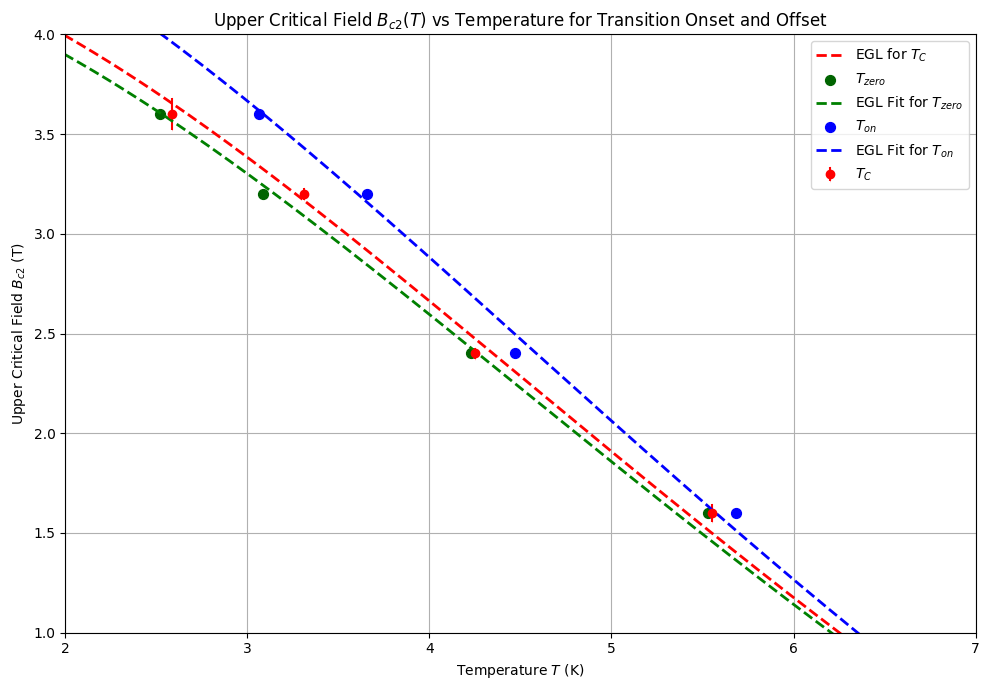

  Tc^MF (Transition Begins, T001): 7.8030 +/- 0.1327 K
  Tc^MF (Transition Ends, T099):   7.7995 +/- 0.1094 K


In [9]:
# ---------------------- Fit for Tzero_vals (Beginning of Transition) ----------------------

# Initial Guesses for Tzero_vals fit
# Bc2_0_guess: Max B_val, slightly extended
initial_Bc2_0_guess_zero = np.max(B_vals) * 1.5
# Tc_MF_guess: T001_val at B=0
initial_Tc_MF_guess_zero = Tzero_vals[np.argmin(B_vals)]

initial_guess_zero = [initial_Bc2_0_guess_zero, initial_Tc_MF_guess_zero]
print(f"Initial guesses (T001): Bc2(0)={initial_Bc2_0_guess_zero:.2f}, Tc_MF={initial_Tc_MF_guess_zero:.2f}")

try:
    popt_zero, pcov_zero = curve_fit(egl_model, Tzero_vals, B_vals, p0=initial_guess_zero)
    Bc2_0_zero_fit, Tc_MF_zero_fit = popt_zero
    perr_zero = np.sqrt(np.diag(pcov_zero))
    Bc2_0_zero_err, Tc_MF_zero_err = perr_zero

    print(f"Fitted Parameters (T001):")
    print(f"  Bc2(0) = {Bc2_0_zero_fit:.4f} +/- {Bc2_0_zero_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_zero_fit:.4f} +/- {Tc_MF_zero_err:.4f} K")

except RuntimeError as e:
    print(f"Error fitting Tzero_vals: {e}")
    Bc2_0_zero_fit, Tc_MF_zero_fit = initial_guess_zero
    perr_zero = [np.nan, np.nan] # Indicate errors are not available

# ------------------- Fit for Ton_vals (End of Transition) -------------------

# Initial Guesses for Ton_vals fit
# Bc2_0_guess: Same logic as T001
initial_Bc2_0_guess_on = np.max(B_vals) * 1.5
# Tc_MF_guess: T099_val at B=0
initial_Tc_MF_guess_on = Ton_vals[np.argmin(B_vals)]

initial_guess_on = [initial_Bc2_0_guess_on, initial_Tc_MF_guess_on]
print(f"Initial guesses (T099): Bc2(0)={initial_Bc2_0_guess_on:.2f}, Tc_MF={initial_Tc_MF_guess_on:.2f}")

try:
    popt_on, pcov_on = curve_fit(egl_model, Ton_vals, B_vals, p0=initial_guess_on)
    Bc2_0_on_fit, Tc_MF_on_fit = popt_on
    perr_on = np.sqrt(np.diag(pcov_on))
    Bc2_0_on_err, Tc_MF_on_err = perr_on

    print(f"Fitted Parameters (T099):")
    print(f"  Bc2(0) = {Bc2_0_on_fit:.4f} +/- {Bc2_0_on_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_on_fit:.4f} +/- {Tc_MF_on_err:.4f} K")

except RuntimeError as e:
    print(f"Error fitting Ton_vals: {e}")
    Bc2_0_on_fit, Tc_MF_on_fit = initial_guess_on
    perr_on = [np.nan, np.nan] # Indicate errors are not available

# ------------------ Plotting the Data and Fits -------------------
T_fine_plot_zero = np.linspace(0, max(Tc_MF_zero_fit, initial_Tc_MF_guess_zero), 200)
Bc2_fit_curve_zero = egl_model(T_fine_plot_zero, Bc2_0_zero_fit, Tc_MF_zero_fit)

T_fine_plot_on = np.linspace(0, max(Tc_MF_on_fit, initial_Tc_MF_guess_on), 200)
Bc2_fit_curve_on = egl_model(T_fine_plot_on, Bc2_0_on_fit, Tc_MF_on_fit)

plt.figure(figsize=(10, 7))

#PLOT TC
plt.errorbar(Tc_vals, B_vals, yerr=Tc_uncertainties, fmt='o', color='red', capsize=.1, label="$T_C$")
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='--', linewidth=2,
         label="EGL for $T_C$")

# Plot TZERO
plt.scatter(Tzero_vals, B_vals, color='darkgreen', s=50, label="$T_{zero}$")
plt.plot(T_fine_plot_zero, Bc2_fit_curve_zero, color='green', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{zero}$")

# Plot TON
plt.scatter(Ton_vals, B_vals, color='blue', s=50, label="$T_{on}$")
plt.plot(T_fine_plot_on, Bc2_fit_curve_on, color='blue', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{on}$")

plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature for Transition Onset and Offset")
plt.legend()
plt.grid(True)
plt.ylim(bottom=1)
plt.ylim(top=4)
plt.xlim(left=2)
plt.xlim(right=7)
plt.tight_layout()
plt.show()

print(f"  Tc^MF (Transition Begins, T001): {Tc_MF_zero_fit:.4f} +/- {Tc_MF_zero_err:.4f} K")
print(f"  Tc^MF (Transition Ends, T099):   {Tc_MF_on_fit:.4f} +/- {Tc_MF_on_err:.4f} K")

### Coherence length

In [10]:
PHI_0 = 2.067833848e-15 # Tesla * meter^2 (CODATA 2018 recommended value)

Bc2_0_val = 4.5530  # Tesla
Bc2_0_err = 0.0405  # Tesla

xsi_0_central = np.sqrt(PHI_0 / (2 * np.pi * Bc2_0_val))
print(f"Central value of xsi(0): {xsi_0_central:.4e} meters ({xsi_0_central * 1e9:.2f} nm)")

xsi_0_uncertainty = 0.5 * np.sqrt(PHI_0 / (2 * np.pi * Bc2_0_val**3)) * np.abs(Bc2_0_err)

print(f"xsi(0) Uncertainty: {xsi_0_uncertainty:.4e} meters ({xsi_0_uncertainty * 1e9:.2f} nm)")

print(f"xsi(0) = {xsi_0_central:.4e} +/- {xsi_0_uncertainty:.4e} m")

Central value of xsi(0): 8.5020e-09 meters (8.50 nm)
xsi(0) Uncertainty: 3.7813e-11 meters (0.04 nm)
xsi(0) = 8.5020e-09 +/- 3.7813e-11 m


### Superconducting Energy Gap

In [11]:
h_bar = 1.0545718e-34  # J*s
fermi_v = 7.004e5 # m/s, Fermi velocity
fermi_v_uncertainty = 0.01e6
#finding superconducting energy gap at 0K
delta_0 = (h_bar * fermi_v) / (np.pi * xsi_0_central)
delta_0_uncertainty = np.sqrt( (h_bar * fermi_v_uncertainty / (np.pi * xsi_0_central))**2 + (h_bar * fermi_v / (np.pi * xsi_0_central**2) * xsi_0_uncertainty)**2 )

print(f"Superconducting energy gap at 0K, Δ(0): {delta_0:.4e} J +/- {delta_0_uncertainty:.4e} J")
# Convert in eV
e_charge = 1.602176634e-19  # Coulombs
delta_0_eV = delta_0 / e_charge
delta_0_eV_uncertainty = delta_0_uncertainty / e_charge

print(f"Superconducting energy gap at 0K, Δ(0): {delta_0_eV:.4e} eV +/- {delta_0_eV_uncertainty:.4e} eV")


Superconducting energy gap at 0K, Δ(0): 2.7654e-21 J +/- 4.1354e-23 J
Superconducting energy gap at 0K, Δ(0): 1.7260e-02 eV +/- 2.5811e-04 eV


## **50-90-10 Filtered Method**

### $T_C$

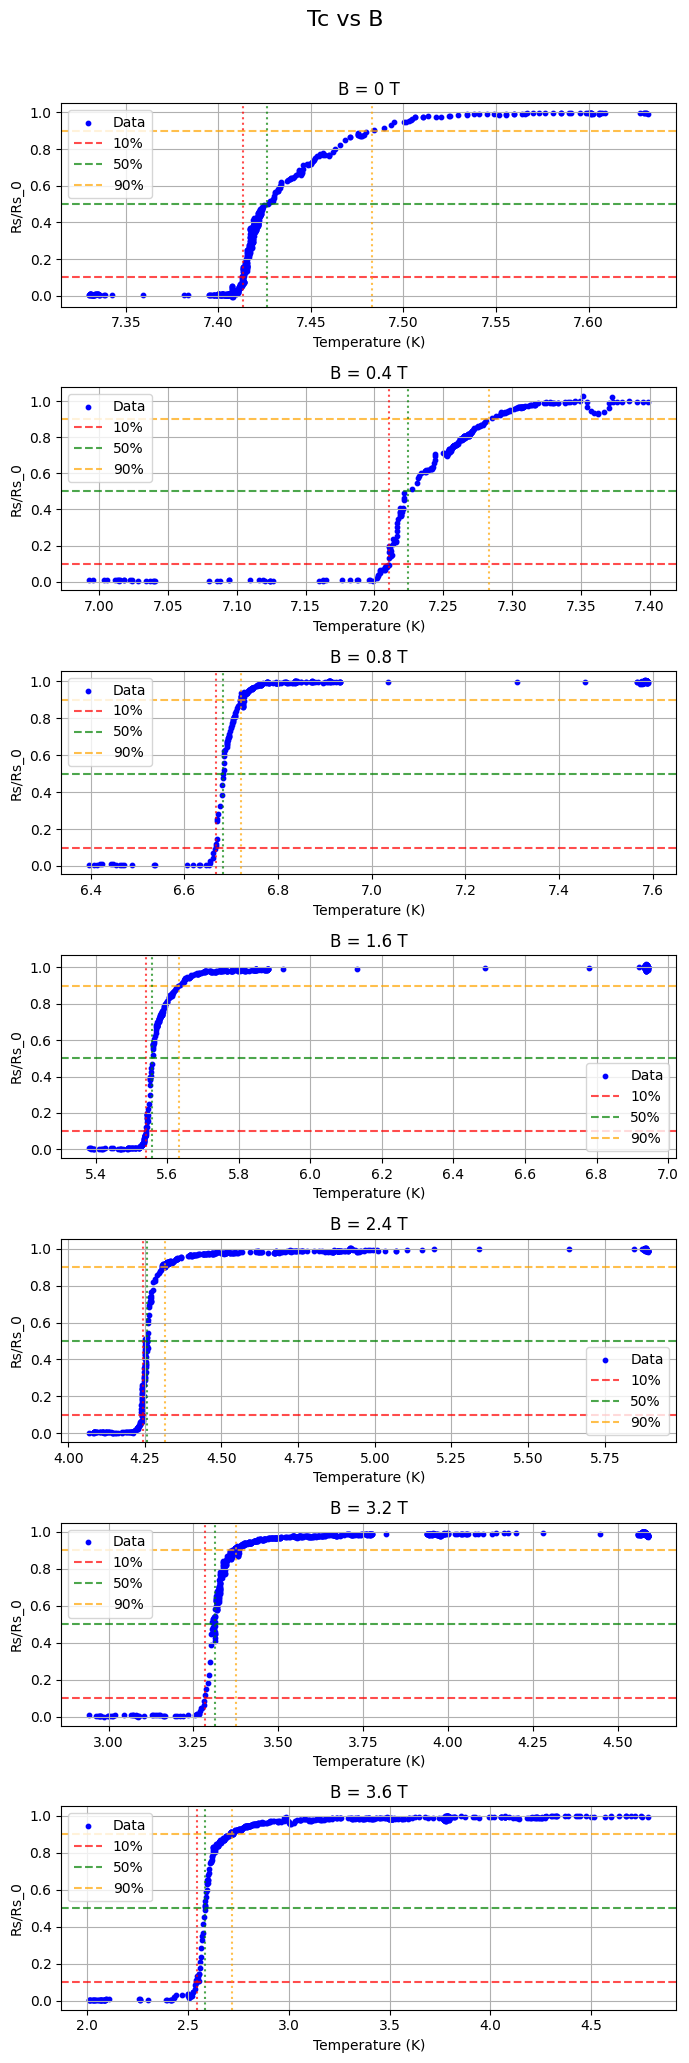

[array(7.42630738), array(7.22410641), array(6.68318757), array(5.55839875), array(4.25744819), array(3.31260641), array(2.58211684)]
[0.034739683267491994, 0.03645866594462266, 0.026826319539047017, 0.04624672037136257, 0.035828733932424583, 0.0458505257098214, 0.0885094150419925]


In [45]:
from scipy.signal import savgol_filter
moving_average_window_size = 11 # Example: average over 7 data points

Tc_vals_filtered = []
Tc_uncertainties_filtered = []

threshold_10_filtered = 0.1
threshold_50_filtered = 0.5  
threshold_90_filtered = 0.9

# --- Plotting ---
fig, axs = plt.subplots(len(B_vals), 1, figsize=(7, 3 * len(B_vals)), sharex=False)
fig.suptitle("Tc vs B", fontsize=16)

for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]

    R_norm = Rs / Rs_0

    sorted_indices = np.argsort(Tf)
    Tf_sorted = Tf[sorted_indices]
    Rs_sorted = R_norm[sorted_indices]

    # # Create the convolution kernel (a window of ones, normalized)
    # window_kernel = np.ones(moving_average_window_size) / moving_average_window_size

    # # 'same' mode ensures output array has same size as input.
    # # This handles edge effects by conceptually padding the input data.
    # Rs_smoothed = np.convolve(Rs_sorted, window_kernel, mode='same')

    Rs_smoothed = savgol_filter(Rs_sorted, window_length=moving_average_window_size, polyorder=3)

    interp_func = interp1d(Rs_smoothed, Tf_sorted, kind='linear',
                          bounds_error=False, fill_value='extrapolate')
    
    T_10_filtered = interp_func(threshold_10_filtered)
    T_50_filtered = interp_func(threshold_50_filtered)
    T_90_filtered = interp_func(threshold_90_filtered)

    if np.isnan(T_10_filtered) or np.isnan(T_50_filtered) or np.isnan(T_90_filtered):
        print(f"Warning: Interpolation failed for B = {x}")

    Tc = T_50_filtered
    uncertainty = (T_90_filtered - T_10_filtered) / 2

    result = {
        'Tc': Tc,
        'uncertainty': uncertainty,
        'T_10_filtered': T_10_filtered,
        'T_50_filtered': T_50_filtered,
        'T_90_filtered': T_90_filtered,
        'Rs_0': Rs_0,
        'B_field': x
    }

    Tc_vals_filtered.append(result['T_50_filtered'])
    Tc_uncertainties_filtered.append(result['uncertainty'])

    ax_r = axs[i]
    
    ax_r.scatter(Tf_sorted, Rs_smoothed, color='blue', s=10, label="Data")
    ax_r.axhline(y=threshold_10_filtered, color='r', linestyle='--', alpha=0.7, label='10%')
    ax_r.axhline(y=threshold_50_filtered, color='g', linestyle='--', alpha=0.7, label='50%')
    ax_r.axhline(y=threshold_90_filtered, color='orange', linestyle='--', alpha=0.7, label='90%')
    ax_r.axvline(x=T_10_filtered, color='r', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_50_filtered, color='g', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_90_filtered, color='orange', linestyle=':', alpha=0.7)
    ax_r.set_ylabel("Rs/Rs_0")
    ax_r.set_xlabel("Temperature (K)")
    ax_r.set_title(f"B = {x} T")
    ax_r.legend()
    ax_r.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print(Tc_vals_filtered)
print(Tc_uncertainties_filtered)

### $T_{zero}$ and $T_{on}$

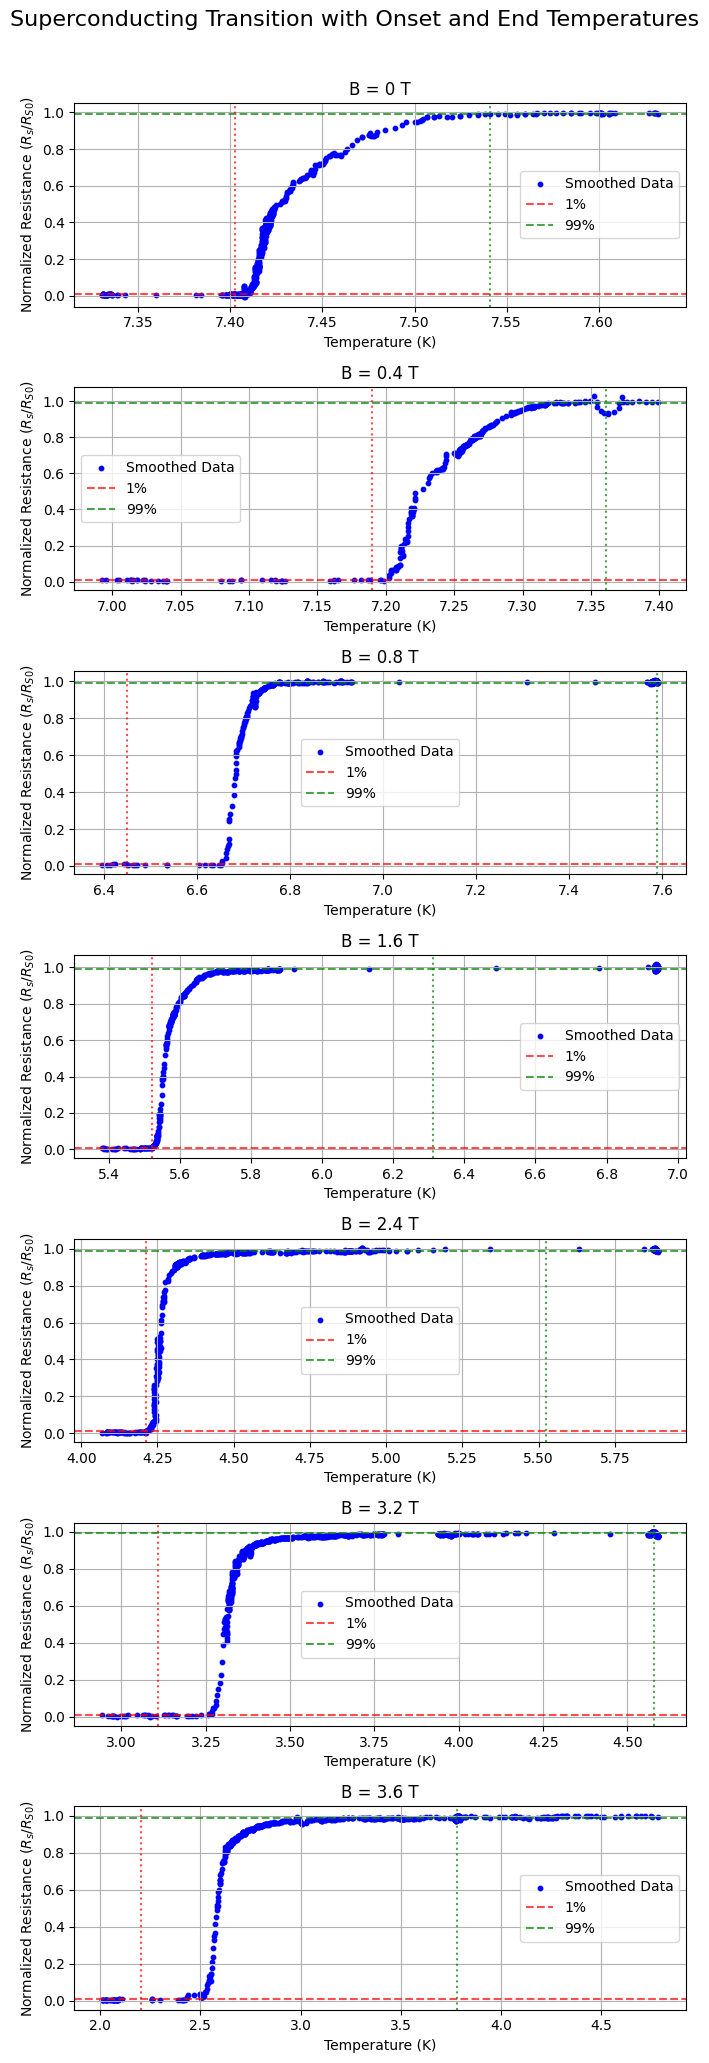

Temperatures at 3%: [array(7.40249023), array(7.18997094), array(6.44970639), array(5.5215881), array(4.21342422), array(3.1082646), array(2.20300857)]
Temperatures at 97%: [array(7.54087556), array(7.36101037), array(7.58867672), array(6.31126406), array(5.52453566), array(4.57868226), array(3.77915455)]


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

Tc_vals_003_filtered = []
Tc_vals_097_filtered = []

threshold_003_filtered = 0.01
threshold_097_filtered = 0.99 

# --- Plotting ---
fig, axs = plt.subplots(len(B_vals), 1, figsize=(7, 3 * len(B_vals)), sharex=False)
fig.suptitle("Superconducting Transition with Onset and End Temperatures", fontsize=16)

for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]

    R_norm = Rs / Rs_0

    sorted_indices = np.argsort(Tf)
    Tf_sorted = Tf[sorted_indices]
    Rs_sorted = R_norm[sorted_indices]

    # Use Savitzky-Golay filter for smoothing
    Rs_smoothed = savgol_filter(Rs_sorted, window_length=moving_average_window_size, polyorder=3)

    interp_func = interp1d(Rs_smoothed, Tf_sorted, kind='linear',
                             bounds_error=False, fill_value='extrapolate')
    
    T_003_filtered = interp_func(threshold_003_filtered)
    T_097_filtered = interp_func(threshold_097_filtered)

    if np.isnan(T_003_filtered) or np.isnan(T_097_filtered):
        print(f"Warning: Interpolation failed for B = {x}")

    result = {
        'T_003_filtered': T_003_filtered,
        'T_097_filtered': T_097_filtered,
        'Rs_0': Rs_0,
        'B_field': x
    }

    Tc_vals_003_filtered.append(result['T_003_filtered'])
    Tc_vals_097_filtered.append(result['T_097_filtered'])

    ax_r = axs[i]
    
    # Plot the smoothed data
    ax_r.scatter(Tf_sorted, Rs_smoothed, color='blue', s=10, label="Smoothed Data")
    ax_r.axhline(y=threshold_003_filtered, color='r', linestyle='--', alpha=0.7, label='1%')
    ax_r.axhline(y=threshold_097_filtered, color='g', linestyle='--', alpha=0.7, label='99%')
    ax_r.axvline(x=T_003_filtered, color='r', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_097_filtered, color='g', linestyle=':', alpha=0.7)
    ax_r.set_ylabel("Normalized Resistance ($R_s/R_{S0}$)")
    ax_r.set_xlabel("Temperature (K)")
    ax_r.set_title(f"B = {x} T")
    ax_r.legend()
    ax_r.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print("Temperatures at 3%:", Tc_vals_003_filtered)
print("Temperatures at 97%:", Tc_vals_097_filtered)

### Phase Diagram

Initial guesses for fit: Bc2(0)=5.40, Tc_MF=7.43

Fitted EGL Parameters:
  Bc2(0) = 4.6666 +/- 0.0580 T
  Tc^MF  = 7.7632 +/- 0.0345 K


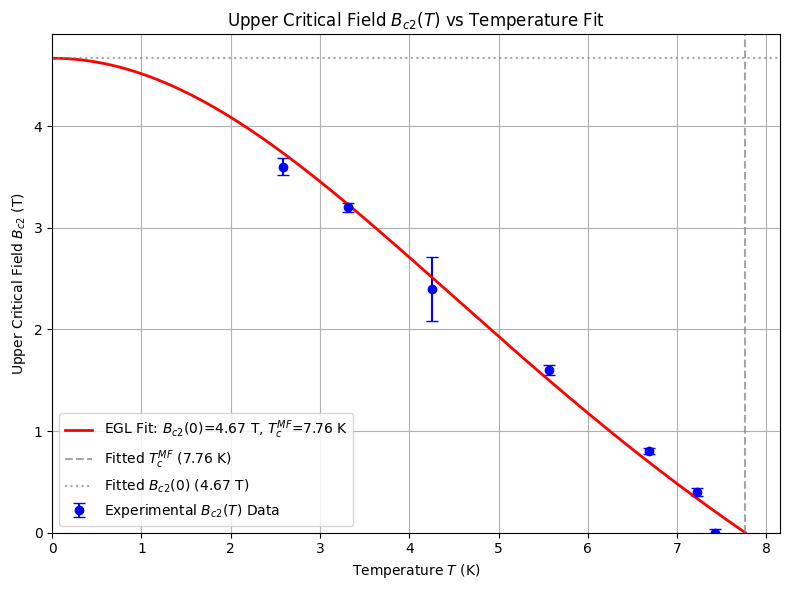

In [ ]:
def egl_model(T, Bc2_0, Tc_MF):
    T_non_zero_check = np.where(T >= Tc_MF, Tc_MF - 1e-9, T) # Small offset for T near Tc_MF
    t = T_non_zero_check / Tc_MF
    result = np.where(t < 1, Bc2_0 * (1 - t**2) / (1 + t**2), 0.0)
    return result

initial_Bc2_0_guess_filtered = np.max(B_vals) * 1.5 

initial_Tc_MF_guess_filtered = Tc_vals_filtered[np.argmin(B_vals)]

initial_guess_filtered = [initial_Bc2_0_guess_filtered, initial_Tc_MF_guess_filtered]

print(f"Initial guesses for fit: Bc2(0)={initial_Bc2_0_guess_filtered:.2f}, Tc_MF={initial_Tc_MF_guess_filtered:.2f}")

try:
    popt, pcov = curve_fit(egl_model, Tc_vals_filtered, B_vals, p0=initial_guess_filtered, sigma=Tc_uncertainties_filtered, absolute_sigma=True)

    Bc2_0_fit_filtered, Tc_MF_fit_filtered = popt
    
    perr = np.sqrt(np.diag(pcov))
    Bc2_0_err_filtered, Tc_MF_err_filtered = perr

    print(f"\nFitted EGL Parameters:")
    print(f"  Bc2(0) = {Bc2_0_fit_filtered:.4f} +/- {Bc2_0_err_filtered:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_fit_filtered:.4f} +/- {Tc_MF_err_filtered:.4f} K")

    T_fit_curve = np.linspace(0, Tc_MF_fit_filtered, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, Bc2_0_fit_filtered, Tc_MF_fit_filtered)

except RuntimeError as e:
    print(f"Error: Could not fit the EGL model. {e}")
    Bc2_0_fit_filtered, Tc_MF_fit_filtered = initial_guess_filtered # Use initial guess for plotting if fit fails
    T_fit_curve = np.linspace(0, initial_Tc_MF_guess_filtered * 1.1, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, initial_Bc2_0_guess_filtered, initial_Tc_MF_guess_filtered)
    perr = [np.nan, np.nan] # Indicate errors are not available

# --- Plotting the Data and Fit ---
plt.figure(figsize=(8, 6))

# Plot experimental data with error bars
plt.errorbar(Tc_vals_filtered, B_vals, yerr=Tc_uncertainties_filtered, fmt='o', color='blue', capsize=4, label="Experimental $B_{c2}(T)$ Data")

# Plot the fitted EGL curve
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='-', linewidth=2,
         label=f"EGL Fit: $B_{{c2}}(0)$={Bc2_0_fit_filtered:.2f} T, $T_c^{{MF}}$={Tc_MF_fit_filtered:.2f} K")

# Add a dashed line for the fitted Tc_MF
plt.axvline(x=Tc_MF_fit_filtered, color='gray', linestyle='--', alpha=0.7, label=f"Fitted $T_c^{{MF}}$ ({Tc_MF_fit_filtered:.2f} K)")
plt.axhline(y=Bc2_0_fit_filtered, color='gray', linestyle=':', alpha=0.7, label=f"Fitted $B_{{c2}}(0)$ ({Bc2_0_fit_filtered:.2f} T)")

plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature Fit")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) 
plt.xlim(left=0) 
plt.tight_layout()
plt.show()

Initial guesses (T001): Bc2(0)=5.40, Tc_MF=7.41
Fitted Parameters (T001):
  Bc2(0) = 4.5056 +/- 0.1275 T
  Tc^MF  = 7.7809 +/- 0.1293 K
Initial guesses (T099): Bc2(0)=5.40, Tc_MF=7.51
Fitted Parameters (T099):
  Bc2(0) = 4.7990 +/- 0.1349 T
  Tc^MF  = 7.8407 +/- 0.1190 K


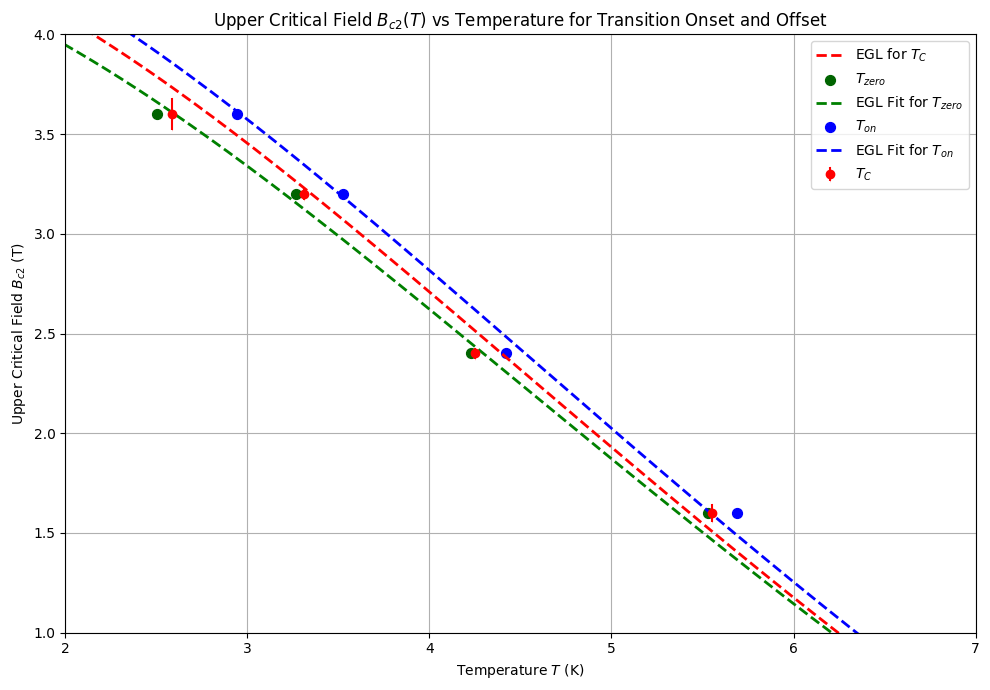

  Tc^MF (Transition Begins, T001): 7.7809 +/- 0.1293 K
  Tc^MF (Transition Ends, T099):   7.8407 +/- 0.1190 K


In [ ]:
# ---------------------- Fit for Tc_vals_003_filtered (Beginning of Transition) ----------------------

# Initial Guesses for Tc_vals_003_filtered fit
# Bc2_0_guess: Max B_val, slightly extended
initial_Bc2_0_guess_003_filtered = np.max(B_vals) * 1.5
# Tc_MF_guess: T001_val at B=0
initial_Tc_MF_guess_003_filtered = Tc_vals_003_filtered[np.argmin(B_vals)]

initial_guess_003_filtered = [initial_Bc2_0_guess_003_filtered, initial_Tc_MF_guess_003_filtered]
print(f"Initial guesses (T001): Bc2(0)={initial_Bc2_0_guess_003_filtered:.2f}, Tc_MF={initial_Tc_MF_guess_003_filtered:.2f}")

try:
    popt_003_filtered, pcov_003_filtered = curve_fit(egl_model, Tc_vals_003_filtered, B_vals, p0=initial_guess_003_filtered)
    Bc2_0_003_fit_filtered, Tc_MF_003_fit_filtered = popt_003_filtered
    perr_003_filtered = np.sqrt(np.diag(pcov_003_filtered))
    Bc2_0_003_err_filtered, Tc_MF_003_err_filtered = perr_003_filtered

    print(f"Fitted Parameters (T001):")
    print(f"  Bc2(0) = {Bc2_0_003_fit_filtered:.4f} +/- {Bc2_0_003_err_filtered:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_003_fit_filtered:.4f} +/- {Tc_MF_003_err_filtered:.4f} K")

except RuntimeError as e:
    print(f"Error fitting Tc_vals_003_filtered: {e}")
    Bc2_0_003_fit_filtered, Tc_MF_003_fit_filtered = initial_guess_003_filtered
    perr_003_filtered = [np.nan, np.nan] # Indicate errors are not available

# ------------------- Fit for Tc_vals_097_filtered (End of Transition) -------------------

# Initial Guesses for Tc_vals_097_filtered fit
# Bc2_0_guess: Same logic as T001
initial_Bc2_0_guess_097_filtered = np.max(B_vals) * 1.5
# Tc_MF_guess: T099_val at B=0
initial_Tc_MF_guess_097_filtered = Tc_vals_097_filtered[np.argmin(B_vals)]

initial_guess_097_filtered = [initial_Bc2_0_guess_097_filtered, initial_Tc_MF_guess_097_filtered]
print(f"Initial guesses (T099): Bc2(0)={initial_Bc2_0_guess_097_filtered:.2f}, Tc_MF={initial_Tc_MF_guess_097_filtered:.2f}")

try:
    popt_097_filtered, pcov_097_filtered = curve_fit(egl_model, Tc_vals_097_filtered, B_vals, p0=initial_guess_097_filtered)
    Bc2_0_097_fit_filtered, Tc_MF_097_fit_filtered = popt_097_filtered
    perr_097_filtered = np.sqrt(np.diag(pcov_097_filtered))
    Bc2_0_099_err, Tc_MF_099_err = perr_097_filtered

    print(f"Fitted Parameters (T099):")
    print(f"  Bc2(0) = {Bc2_0_097_fit_filtered:.4f} +/- {Bc2_0_099_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_097_fit_filtered:.4f} +/- {Tc_MF_099_err:.4f} K")

except RuntimeError as e:
    print(f"Error fitting Tc_vals_097_filtered: {e}")
    Bc2_0_097_fit_filtered, Tc_MF_097_fit_filtered = initial_guess_097_filtered
    perr_097_filtered = [np.nan, np.nan] # Indicate errors are not available

# ------------------ Plotting the Data and Fits -------------------
T_fine_plot_001 = np.linspace(0, max(Tc_MF_003_fit_filtered, initial_Tc_MF_guess_003_filtered), 200)
Bc2_fit_curve_001 = egl_model(T_fine_plot_001, Bc2_0_003_fit_filtered, Tc_MF_003_fit_filtered)

T_fine_plot_099 = np.linspace(0, max(Tc_MF_097_fit_filtered, initial_Tc_MF_guess_097_filtered), 200)
Bc2_fit_curve_099 = egl_model(T_fine_plot_099, Bc2_0_097_fit_filtered, Tc_MF_097_fit_filtered)

plt.figure(figsize=(10, 7))

#PLOT TC
plt.errorbar(Tc_vals, B_vals, yerr=Tc_uncertainties, fmt='o', color='red', capsize=.1, label="$T_C$")
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='--', linewidth=2,
         label="EGL for $T_C$")

# Plot TZERO
plt.scatter(Tc_vals_003_filtered, B_vals, color='darkgreen', s=50, label="$T_{zero}$")
plt.plot(T_fine_plot_001, Bc2_fit_curve_001, color='green', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{zero}$")

# Plot TON
plt.scatter(Tc_vals_097_filtered, B_vals, color='blue', s=50, label="$T_{on}$")
plt.plot(T_fine_plot_099, Bc2_fit_curve_099, color='blue', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{on}$")

plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature for Transition Onset and Offset")
plt.legend()
plt.grid(True)
plt.ylim(bottom=1)
plt.ylim(top=4)
plt.xlim(left=2)
plt.xlim(right=7)
plt.tight_layout()
plt.show()

print(f"  Tc^MF (Transition Begins, T001): {Tc_MF_003_fit_filtered:.4f} +/- {Tc_MF_003_err_filtered:.4f} K")
print(f"  Tc^MF (Transition Ends, T099):   {Tc_MF_097_fit_filtered:.4f} +/- {Tc_MF_099_err:.4f} K")

### Coherence Length

In [ ]:
PHI_0 = 2.067833848e-15 # Tesla * meter^2 (CODATA 2018 recommended value)

# --- Your given Bc2(0) value and its uncertainty ---
Bc2_0_val_filtered = 4.5290
Bc2_0_err_filtered = 0.0604 

xsi_0_central_filtered = np.sqrt(PHI_0 / (2 * np.pi * Bc2_0_val_filtered))
print(f"Central value of xsi(0): {xsi_0_central_filtered:.4e} meters ({xsi_0_central_filtered * 1e9:.2f} nm)")

xsi_0_uncertainty_filtered = 0.5 * np.sqrt(PHI_0 / (2 * np.pi * Bc2_0_val_filtered**3)) * np.abs(Bc2_0_err)

print(f"xsi(0) Uncertainty: {xsi_0_uncertainty_filtered:.4e} meters ({xsi_0_uncertainty_filtered * 1e9:.2f} nm)")

print(f"xsi(0) = {xsi_0_central_filtered:.4e} +/- {xsi_0_uncertainty_filtered:.4e} T")

Central value of xsi(0): 8.5245e-09 meters (8.52 nm)
xsi(0) Uncertainty: 3.8114e-11 meters (0.04 nm)
xsi(0) = 8.5245e-09 +/- 3.8114e-11 T


## Sigmoid

Initial guesses: L=2.65, k=2.00, T0=7.43, C=0.00

Fitted parameters:
  L = 2.3046 +/- 0.0317
  k = 176.5746 +/- 8.2918
  T0 (Midpoint Tc) = 7.4226 +/- 0.0002 K
  C = 0.0000 +/- 0.0218


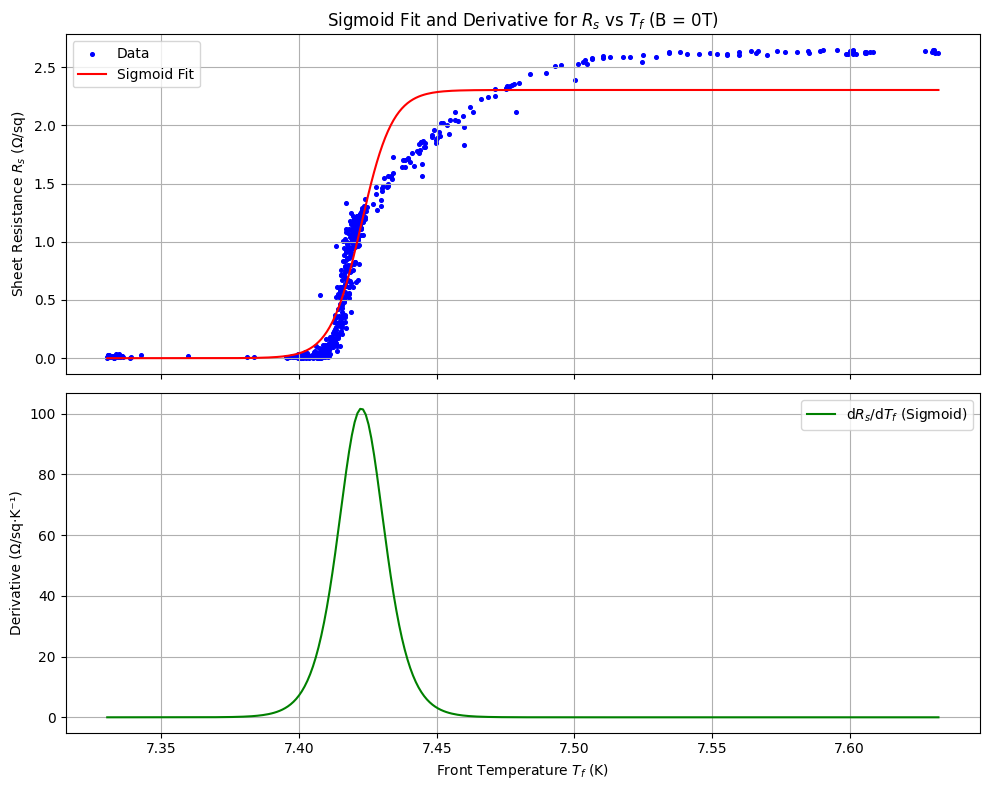

Initial guesses: L=2.68, k=2.00, T0=7.22, C=0.00

Fitted parameters:
  L = 2.5642 +/- 0.0314
  k = 54.9283 +/- 1.6039
  T0 (Midpoint Tc) = 7.2336 +/- 0.0007 K
  C = 0.0000 +/- 0.0234


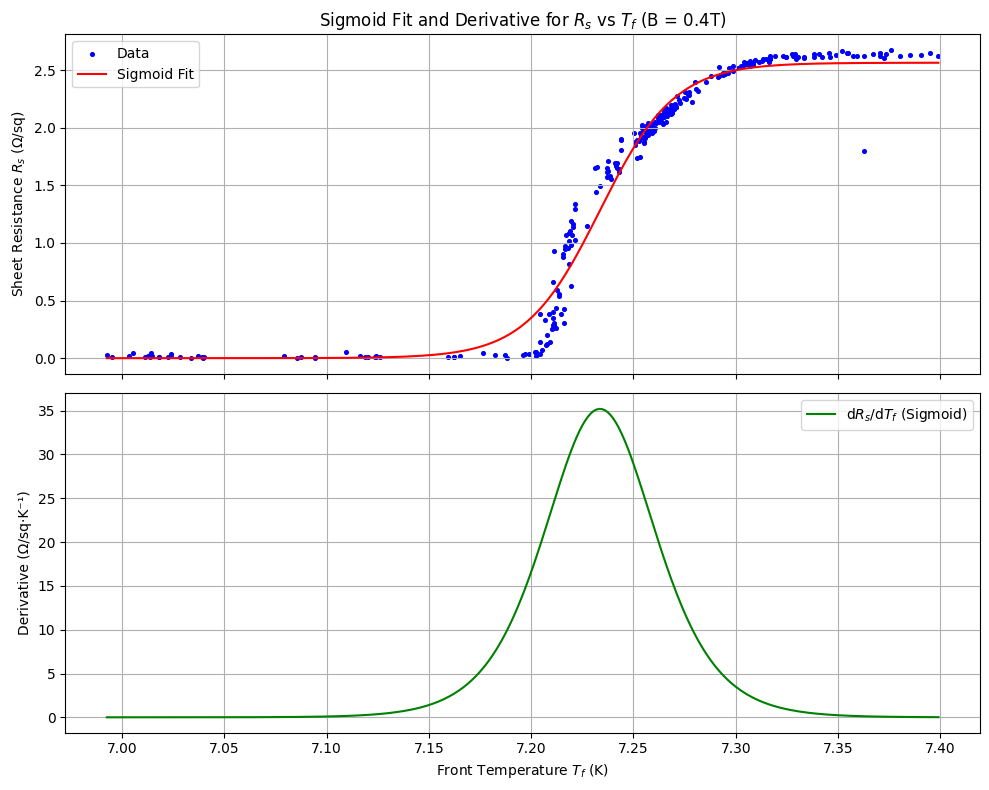

Initial guesses: L=2.72, k=2.00, T0=6.68, C=0.00

Fitted parameters:
  L = 2.6204 +/- 0.0221
  k = 76.3427 +/- 2.1285
  T0 (Midpoint Tc) = 6.6843 +/- 0.0004 K
  C = 0.0000 +/- 0.0212


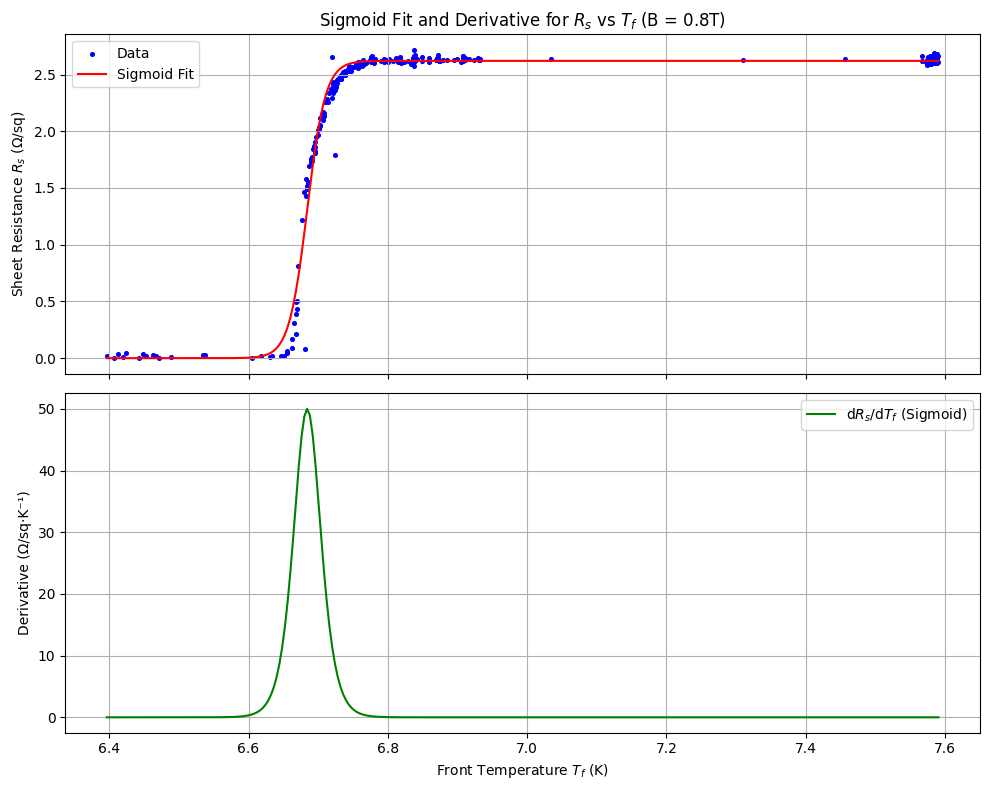

Initial guesses: L=2.82, k=2.00, T0=5.56, C=0.00

Fitted parameters:
  L = 2.5847 +/- 0.0197
  k = 70.3961 +/- 1.7334
  T0 (Midpoint Tc) = 5.5627 +/- 0.0004 K
  C = 0.0000 +/- 0.0181


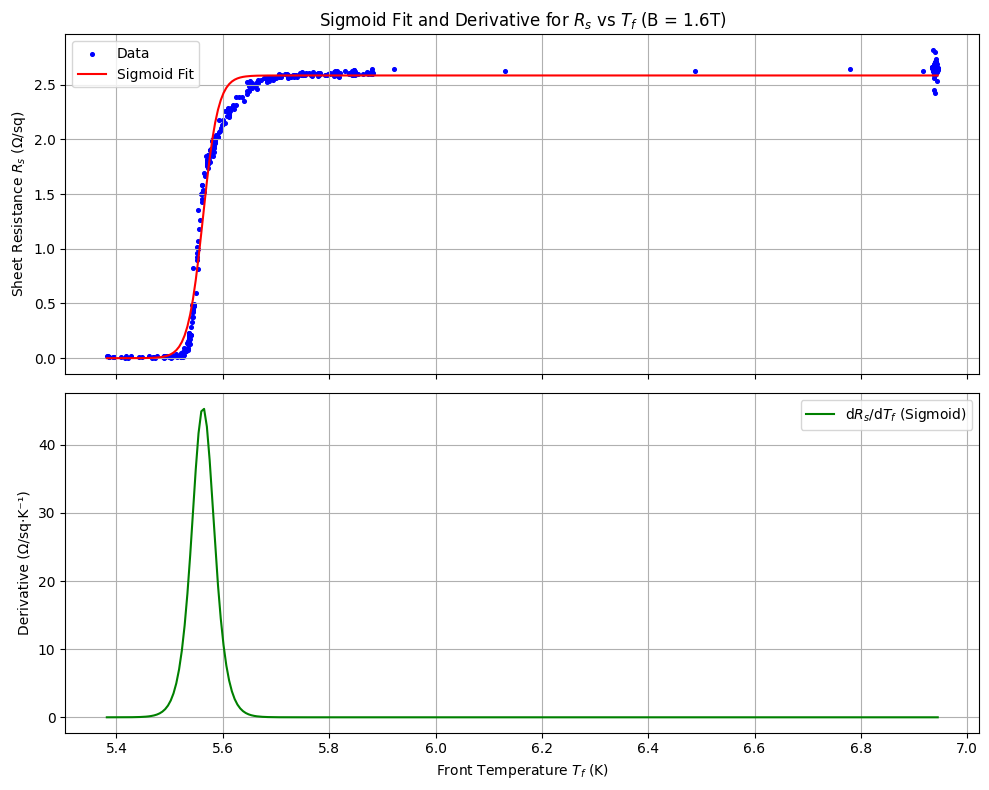

Initial guesses: L=2.68, k=2.00, T0=4.25, C=0.00

Fitted parameters:
  L = 2.5842 +/- 0.0198
  k = 87.9030 +/- 3.3246
  T0 (Midpoint Tc) = 4.2576 +/- 0.0004 K
  C = 0.0000 +/- 0.0186


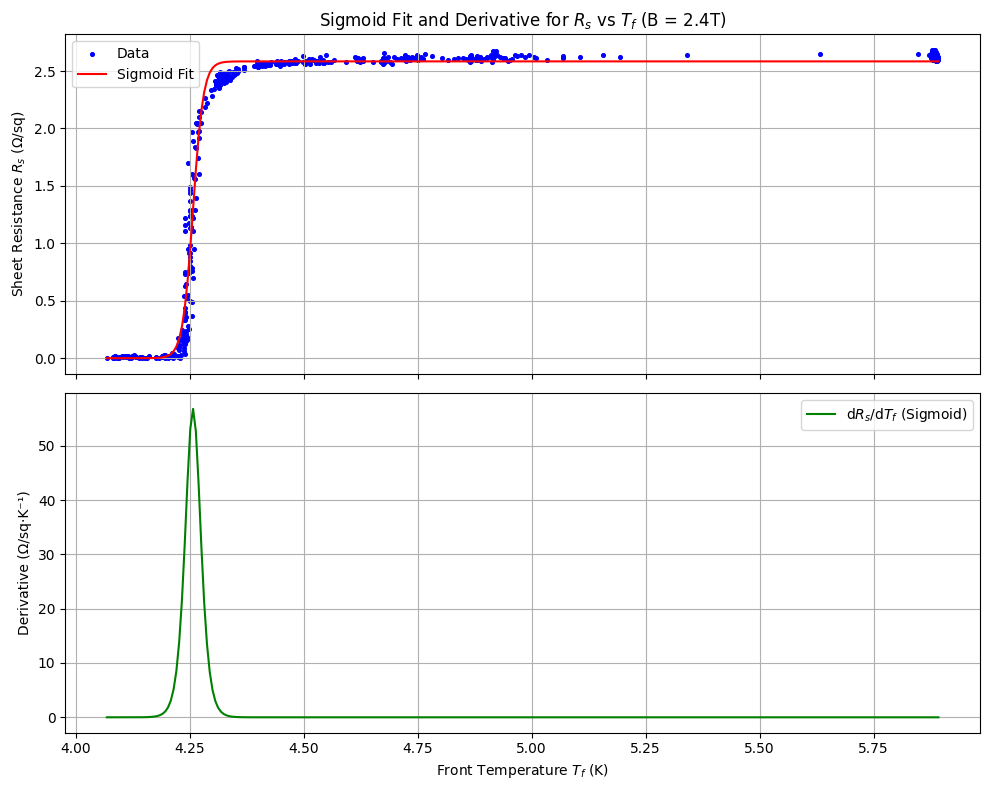

Initial guesses: L=2.66, k=2.00, T0=3.31, C=0.00

Fitted parameters:
  L = 2.5770 +/- 0.0169
  k = 51.7764 +/- 1.2133
  T0 (Midpoint Tc) = 3.3098 +/- 0.0005 K
  C = 0.0000 +/- 0.0161


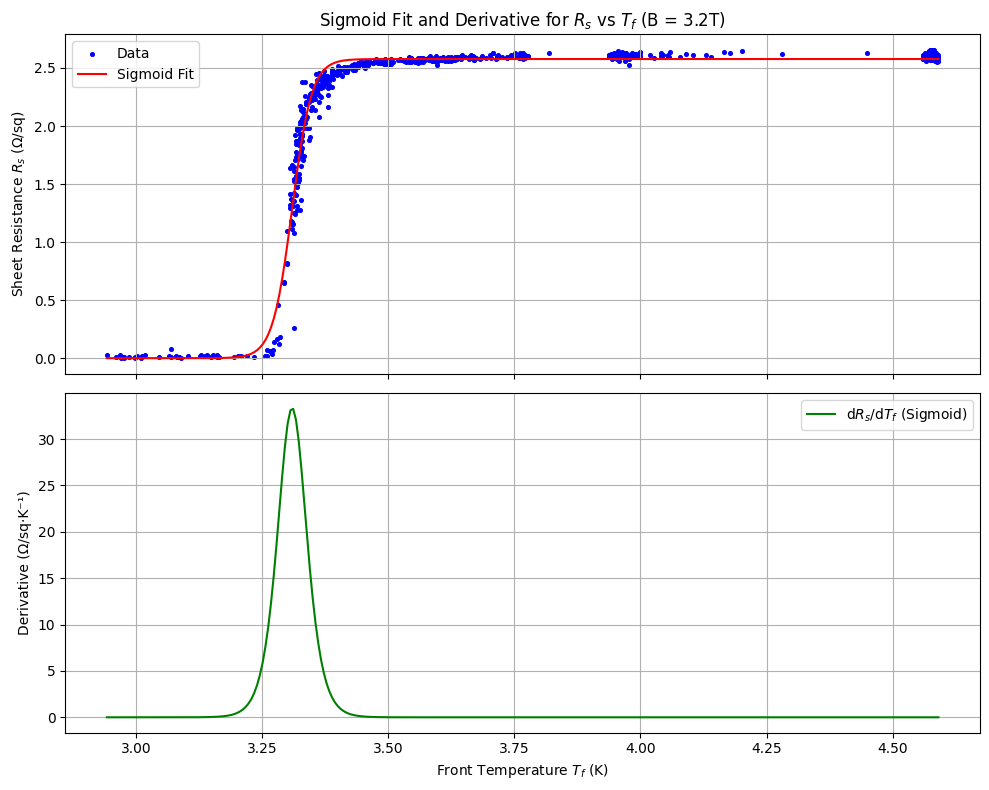

Initial guesses: L=2.70, k=2.00, T0=2.59, C=0.00

Fitted parameters:
  L = 2.5670 +/- 0.0134
  k = 36.6417 +/- 0.7736
  T0 (Midpoint Tc) = 2.5859 +/- 0.0007 K
  C = 0.0000 +/- 0.0126


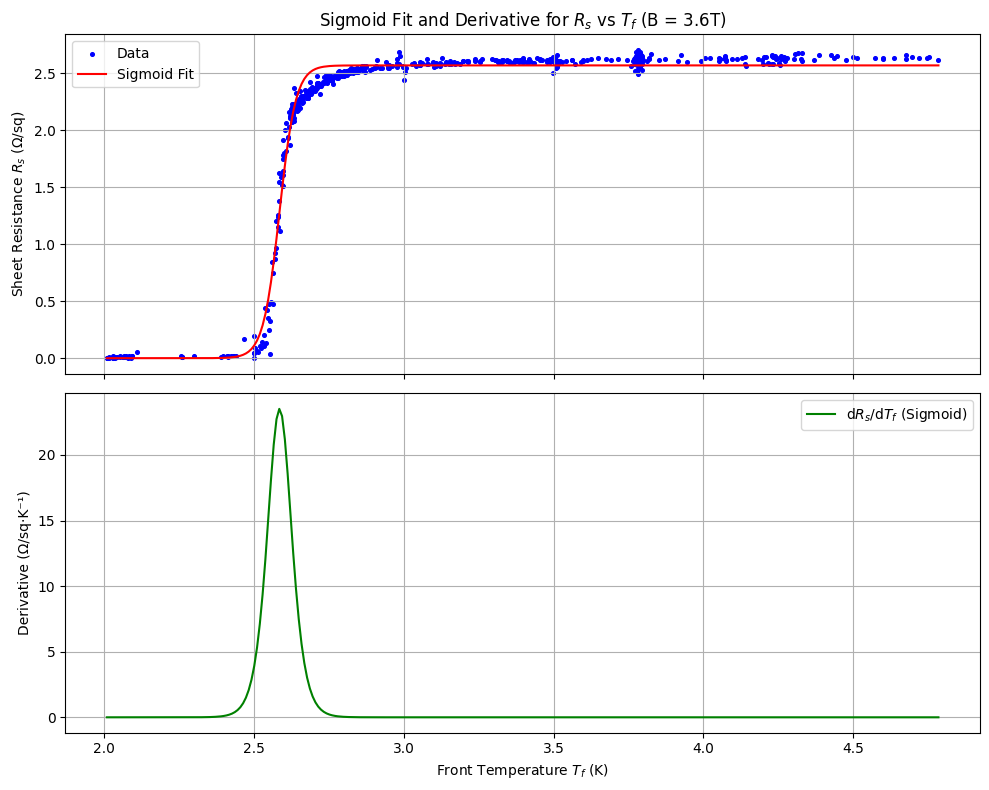

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline # Keep for comparison if desired


# Define the Sigmoid function
def sigmoid_function(T, L, k, T0, C):
    """
    Logistic Sigmoid function for fitting superconducting transition.
    T: Temperature
    L: Max resistance change (Amplitude from base to plateau)
    k: Steepness of the transition
    T0: Midpoint temperature (often taken as Tc)
    C: Minimum resistance (residual resistance)
    """
    return L / (1 + np.exp(-k * (T - T0))) + C


for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]  

    sorted_indices = np.argsort(Tf)
    Tf_sorted = Tf[sorted_indices]
    Rs_sorted = Rs[sorted_indices]

    #Rs_sorted = Rs_sorted / Rs_0

    # --- Initial Guess for Sigmoid Parameters ---
    # This is crucial for successful fitting. Adjust these based on your data's rough shape.
    # L_guess: roughly the difference between max and min resistance
    L_guess = np.max(Rs_sorted) - np.min(Rs_sorted)
    # T0_guess: temperature at roughly 50% of the transition
    T0_guess = Tf_sorted[np.argmin(np.abs(Rs_sorted - (np.min(Rs_sorted) + L_guess / 2)))]
    # k_guess: steepness. A positive value for increasing R with T.
    # Typically, a narrower transition means a larger k. Start with something like 2-5.
    k_guess = 2.0
    # C_guess: minimum resistance (value at lowest temperatures)
    C_guess = np.min(Rs_sorted)

    initial_guess = [L_guess, k_guess, T0_guess, C_guess]

    print(f"Initial guesses: L={L_guess:.2f}, k={k_guess:.2f}, T0={T0_guess:.2f}, C={C_guess:.2f}")

    try:
        # bounds: optional, to constrain parameters. e.g., (0, np.inf) for L and k
        # We want L, k > 0. T0 within temp range. C > 0 (or around 0).
        popt, pcov = curve_fit(sigmoid_function, Tf_sorted, Rs_sorted, p0=initial_guess,
                            bounds=([0, 0, Tf_sorted.min(), 0], [np.inf, np.inf, Tf_sorted.max(), np.inf]))

        L_fit, k_fit, T0_fit, C_fit = popt
        perr = np.sqrt(np.diag(pcov)) # Standard deviations of the parameters

        print(f"\nFitted parameters:")
        print(f"  L = {L_fit:.4f} +/- {perr[0]:.4f}")
        print(f"  k = {k_fit:.4f} +/- {perr[1]:.4f}")
        print(f"  T0 (Midpoint Tc) = {T0_fit:.4f} +/- {perr[2]:.4f} K")
        print(f"  C = {C_fit:.4f} +/- {perr[3]:.4f}")

        # Evaluate the fitted sigmoid on a fine grid
        Tf_fine_sigmoid = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 300)
        Rs_fine_sigmoid = sigmoid_function(Tf_fine_sigmoid, *popt)

        # --- Compute first derivative of the Sigmoid fit ---
        # The derivative of L / (1 + e^(-k(T - T0))) + C is:
        # L * k * e^(-k(T - T0)) / (1 + e^(-k(T - T0)))^2
        def sigmoid_derivative(T, L, k, T0, C):
            exp_term = np.exp(-k * (T - T0))
            return L * k * exp_term / ((1 + exp_term)**2)

        Rs_derivative_sigmoid = sigmoid_derivative(Tf_fine_sigmoid, *popt)

    except RuntimeError as e:
        print(f"Error: Could not fit sigmoid function. {e}")
        L_fit, k_fit, T0_fit, C_fit = initial_guess # Use initial guess for plotting if fit fails
        Rs_fine_sigmoid = sigmoid_function(Tf_fine_sigmoid, *initial_guess)
        Rs_derivative_sigmoid = np.zeros_like(Tf_fine_sigmoid) # Placeholder if derivative fails


    # --- To get 10%, 50%, 90% thresholds from the Sigmoid fit ---
    # 1. Normalize the fitted Sigmoid curve
    # The maximum resistance in the normal state (Rs_0) for the sigmoid is approximately (L_fit + C_fit)
    # The minimum resistance is C_fit.
    # We normalize relative to the *total transition amplitude* (L_fit).
    # So, normalized_Rs = (Rs - C_fit) / L_fit

    # if 'popt' in locals(): # Only proceed if fit was successful
    #     # Calculate the effective Rs_0 from the sigmoid fit: this is the normal state resistance
    #     Rs_normal_state_sigmoid = L_fit + C_fit

    #     # Create the normalized sigmoid curve
    #     Rs_norm_sigmoid_fine = (Rs_fine_sigmoid - C_fit) / (L_fit)

    #     # Now, use interp1d on the normalized sigmoid data
    #     # Ensure R_norm_sigmoid_fine is monotonically increasing (which it should be if k > 0)
    #     interp_func_sigmoid = interp1d(Rs_norm_sigmoid_fine, Tf_fine_sigmoid, kind='linear',
    #                                 bounds_error=False, fill_value='extrapolate')

    #     # Get the T values corresponding to the thresholds
    #     T_10_sigmoid = interp_func_sigmoid(threshold_10)
    #     T_50_sigmoid = interp_func_sigmoid(threshold_50)
    #     T_90_sigmoid = interp_func_sigmoid(threshold_90)

    #     #print(f"\nThresholds derived from Sigmoid Fit:")
    #     #print(f"  T_10 = {T_10_sigmoid:.4f} K")
    #     print(f"  T_50 (Tc) = {T_50_sigmoid:.4f} K") # T0_fit from Sigmoid is usually very close to this
    #     # print(f"  T_90 = {T_90_sigmoid:.4f} K")
    #     # print(f"  Transition Width (T_90 - T_10) = {(T_90_sigmoid - T_10_sigmoid):.4f} K")
    #     print(f"  Tc Uncertainty ((T_90 - T_10) / 2) = {((T_90_sigmoid - T_10_sigmoid) / 2):.4f} K")
    # else:
    #     print("\nSigmoid fit failed, cannot calculate thresholds based on the fit.")


    # --- Plotting ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot original data and Sigmoid fit
    ax[0].scatter(Tf_sorted, Rs_sorted, s=7, color='blue', label="Data")
    ax[0].plot(Tf_fine_sigmoid, Rs_fine_sigmoid, color='red', label="Sigmoid Fit")
    ax[0].set_ylabel("Sheet Resistance $R_s$ (Ω/sq)")
    ax[0].set_title(f"Sigmoid Fit and Derivative for $R_s$ vs $T_f$ (B = {x}T)") # Using fixed B=2.4T for this example
    ax[0].legend()
    ax[0].grid(True)

    # ax[0].axhline(y=threshold_10, color='r', linestyle='--', alpha=0.7, label='10%')
    # ax[0].axhline(y=threshold_50, color='g', linestyle='--', alpha=0.7, label='50%')
    # ax[0].axhline(y=threshold_90, color='orange', linestyle='--', alpha=0.7, label='90%')
    # ax_r.axvline(x=T_10, color='r', linestyle=':', alpha=0.7)
    # ax_r.axvline(x=T_50, color='g', linestyle=':', alpha=0.7)
    # ax_r.axvline(x=T_90, color='orange', linestyle=':', alpha=0.7)

    # Plot derivative of Sigmoid
    ax[1].plot(Tf_fine_sigmoid, Rs_derivative_sigmoid, color='green', label="d$R_s$/d$T_f$ (Sigmoid)")
    ax[1].set_xlabel("Front Temperature $T_f$ (K)")
    ax[1].set_ylabel("Derivative (Ω/sq·K⁻¹)")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

## **Fermi-Dirac like function**

In [ ]:
from scipy.optimize import curve_fit

Rho_0 = 2.6427

# Fermi-Dirac like function for superconducting transition
def FD_model(T, T_c, delta_T):
    return Rho_0 / (1 + np.exp(-(T - T_c) / delta_T))

def dR_dT_FD(T, T_c, delta_T):
    exp_term = np.exp(-(T - T_c) / delta_T)
    return (Rho_0 / delta_T) * (exp_term / (1 + exp_term)**2)

# Get filtered Tf and Rs data 
Tf = filtered_data['Tf_3.6']
Rs = filtered_data['Rs_3.6']

# Sort
sorted_idx = np.argsort(Tf)
Tf_sorted = Tf[sorted_idx]
Rs_sorted = Rs[sorted_idx]  # Normalize Rs by Rs_0

# Fit
popt, _ = curve_fit(FD_model, Tf_sorted, Rs_sorted, p0=[Tf_sorted[np.argmax(np.gradient(-Rs))], 0.1])
T_c_fit, delta_T_fit = popt

# Evaluate model
Tf_fit = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 500)
Rs_fit = FD_model(Tf_fit, *popt)

#DERIVATIVE
dRs_numeric = np.gradient(Rs_fit, Tf_fit) #numerical gradient to camper with the fit
# Remove NaNs or infs from both arrays
valid_mask = np.isfinite(dRs_numeric) & np.isfinite(Tf_fit)
Tf_valid = Tf_fit[valid_mask]
dRs_numeric_valid = dRs_numeric[valid_mask]

popt_dR, _ = curve_fit(dR_dT_FD, Tf_valid, dRs_numeric_valid, p0=popt)
dRs_fit = dR_dT_FD(Tf_valid, *popt_dR )

print('Tc (from derivative fit):', popt_dR[0])



Tc (from derivative fit): 2.588185399417631


In [ ]:
# find FWHM = Tc(90%) + Tc(10%) 
T_fwhm=[]
for i in range(len(Rs_fit)): 
    if(dRs_fit[i]>np.max(dRs_fit)/2): T_fwhm.append(Tf_fit[i])
FWHM = np.max(T_fwhm)-np.min(T_fwhm)

print(FWHM)

0.10005875350701432


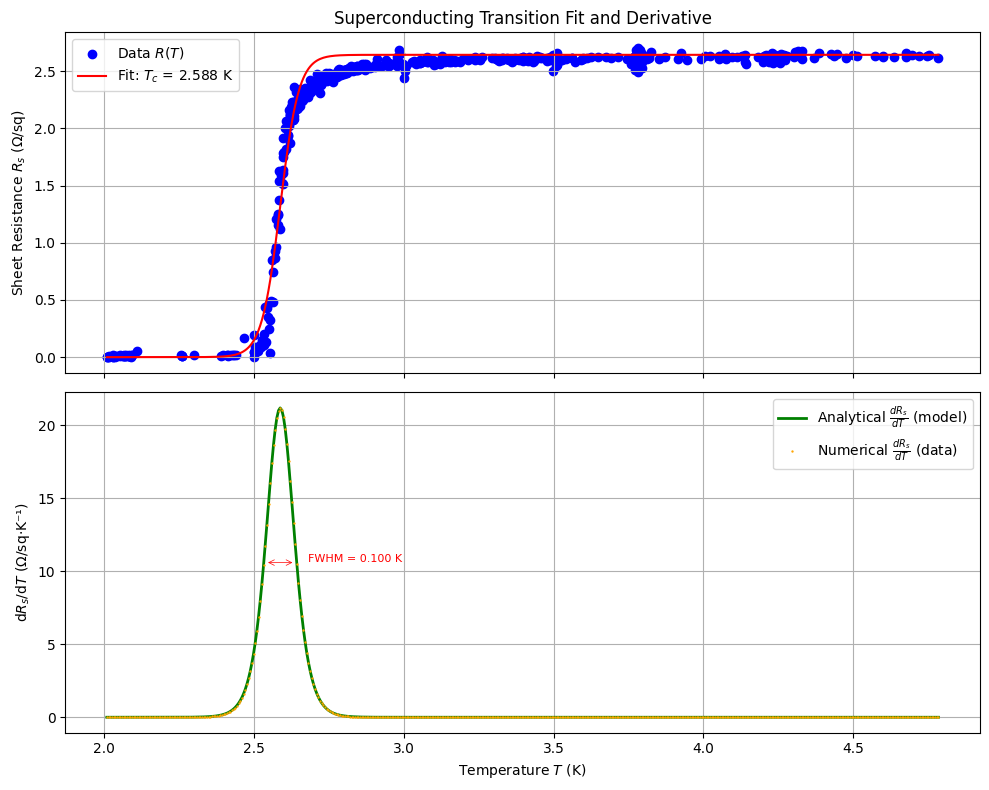

In [ ]:

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# R(T) and fit 
ax[0].scatter(Tf_sorted, Rs_sorted, label="Data $R(T)$", color='blue')
ax[0].plot(Tf_fit, Rs_fit, label=f"Fit: $T_c$ = {T_c_fit:.3f} K", color='red')
ax[0].set_ylabel("Sheet Resistance $R_s$ (Ω/sq)")
ax[0].set_title("Superconducting Transition Fit and Derivative")
ax[0].legend()
ax[0].grid(True)

# dR/dT and model derivative
label_text = f"FWHM = {FWHM:.3f} K"

# Draw the double arrow using annotate
ax[1].annotate(
    '', 
    xy=(T_c_fit - FWHM/2 + FWHM, np.max(dRs_fit)/2), 
    xytext=(T_c_fit - FWHM/2, np.max(dRs_fit)/2), 
    arrowprops=dict(arrowstyle='<->', color='red', linewidth=.5)
)

# Place the label in the middle of the arrow
x_mid = T_c_fit 
ax[1].text(x_mid+FWHM/2+.2, np.max(dRs_fit)/2-.1 , label_text, ha='center', va='bottom', fontsize=8, color='red')


ax[1].plot(Tf_valid, dRs_fit, label=r"Analytical $\frac{dR_s}{dT}$ (model)", color='green', linewidth=2)
ax[1].plot(Tf_fit, dRs_numeric, 'o', label=r"Numerical $\frac{dR_s}{dT}$ (data)", color='orange', markersize=.7)
#ax[1].plot([T_c_fit - FWHM/2, T_c_fit + FWHM/2], [np.max(dRs_fit)/2, np.max(dRs_fit)/2], color='black', linewidth=2)
ax[1].set_xlabel("Temperature $T$ (K)")
ax[1].set_ylabel("d$R_s$/d$T$ (Ω/sq·K⁻¹)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

### $T_C$

B = 0.4, T_c = 7.23528 K +- 0.03377 K
B = 0.8, T_c = 6.68457 K +- 0.02273 K
B = 1.6, T_c = 5.56376 K +- 0.02505 K
B = 2.4, T_c = 4.25854 K +- 0.01827 K
B = 3.2, T_c = 3.31047 K +- 0.03633 K
B = 3.6, T_c = 2.58819 K +- 0.05003 K


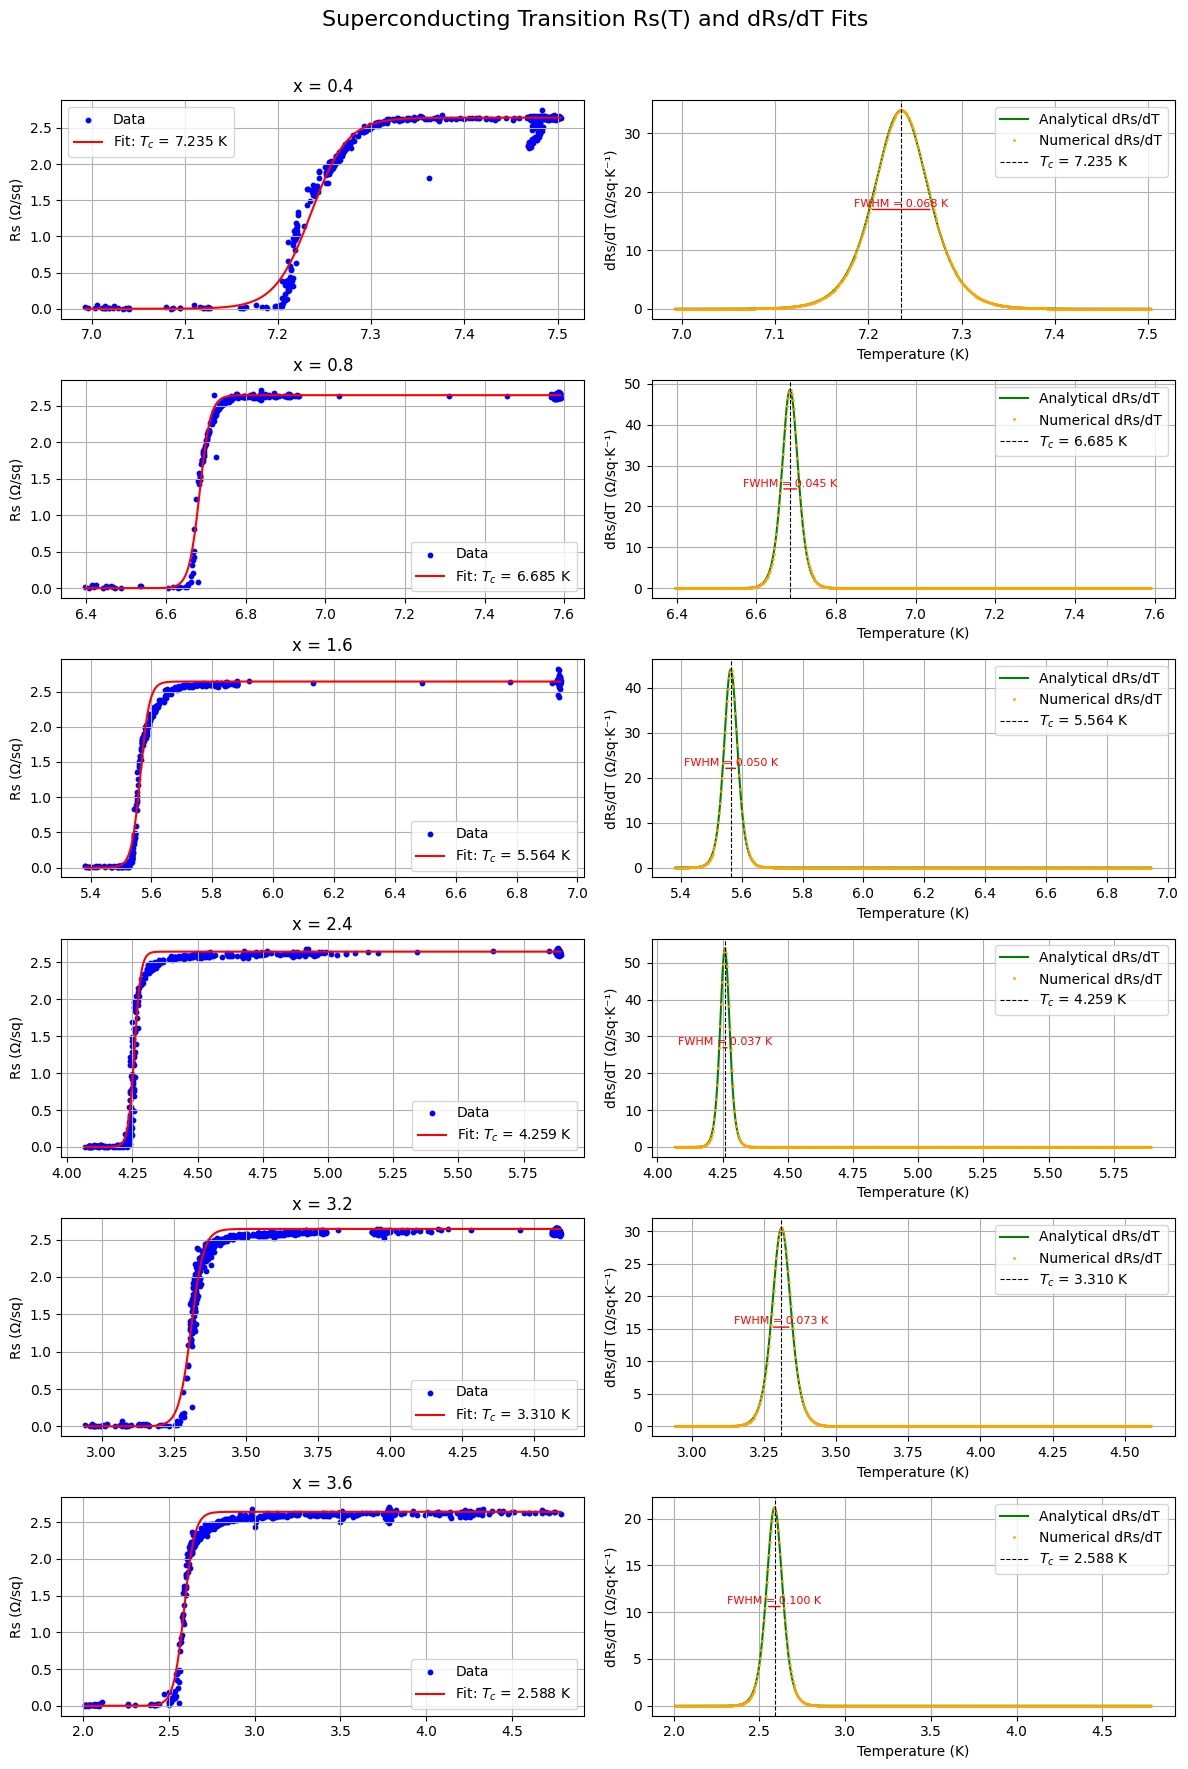

In [ ]:
from scipy.optimize import curve_fit

Rho_0 = 2.6427

Tc_vals_FD = []
Tc_uncertainties_FD = []

# Fermi-Dirac like function for superconducting transition
def FD_model(T, T_c, delta_T):
    return Rho_0 / (1 + np.exp(-(T - T_c) / delta_T))

def dR_dT_FD(T, T_c, delta_T):
    exp_term = np.exp(-(T - T_c) / delta_T)
    return (Rho_0 / delta_T) * (exp_term / (1 + exp_term)**2)

# --- X values from your original dataset names ---
x_vals = [0.4, 0.8, 1.6, 2.4, 3.2, 3.6]

# --- Plotting ---
fig, axs = plt.subplots(len(x_vals), 2, figsize=(12, 3 * len(x_vals)), sharex=False)
fig.suptitle("Superconducting Transition Rs(T) and dRs/dT Fits", fontsize=16)

for i, x in enumerate(x_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    # Sort
    sorted_idx = np.argsort(Tf)
    Tf_sorted = Tf[sorted_idx]
    Rs_sorted = Rs[sorted_idx]

    # Initial guess for Tc: where -dR/dT peaks
    guess_Tc = Tf_sorted[np.argmax(np.gradient(-Rs_sorted))]
    try:
        popt, _ = curve_fit(FD_model, Tf_sorted, Rs_sorted, p0=[guess_Tc, 0.1])
        T_c_fit, delta_T_fit = popt
    except RuntimeError:
        print(f"Fit did not converge for x={x}")
        continue

    # Evaluate Rs(T) model
    Tf_fit = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 500)
    Rs_fit = FD_model(Tf_fit, *popt)

    # Numerical derivative
    dRs_numeric = np.gradient(Rs_fit, Tf_fit)

    # Remove NaNs/infs
    valid_mask = np.isfinite(dRs_numeric) & np.isfinite(Tf_fit)
    Tf_valid = Tf_fit[valid_mask]
    dRs_numeric_valid = dRs_numeric[valid_mask]

    # Fit dR/dT model (optional — or just use analytical version)
    try:
        popt_dR, _ = curve_fit(dR_dT_FD, Tf_valid, dRs_numeric_valid, p0=popt)
        dRs_fit = dR_dT_FD(Tf_valid, *popt_dR)
    except RuntimeError:
        dRs_fit = dR_dT_FD(Tf_valid, *popt)

    # --- FWHM Calculation ---
    half_max = np.max(dRs_fit) / 2
    T_fwhm = Tf_valid[dRs_fit > half_max]
    FWHM = T_fwhm.max() - T_fwhm.min() if len(T_fwhm) > 1 else np.nan

    Tc_vals_FD.append(T_c_fit)
    Tc_uncertainties_FD.append(FWHM / 2)

    # --- Plot Rs(T) ---
    ax_r = axs[i, 0]
    ax_r.scatter(Tf_sorted, Rs_sorted, color='blue', s=10, label="Data")
    ax_r.plot(Tf_fit, Rs_fit, color='red', label=f"Fit: $T_c$ = {T_c_fit:.3f} K")
    ax_r.set_ylabel("Rs (Ω/sq)")
    ax_r.set_title(f"x = {x}")
    ax_r.legend()
    ax_r.grid(True)

    # --- Plot dRs/dT ---
    ax_d = axs[i, 1]
    ax_d.plot(Tf_valid, dRs_fit, label="Analytical dRs/dT", color='green')
    ax_d.plot(Tf_valid, dRs_numeric_valid, '.', label="Numerical dRs/dT", color='orange', markersize=2)


    filtered_data[f'T_{x}'] = [ T_c_fit, delta_T_fit] 

    # Draw FWHM arrow
    ax_d.annotate(
        '',
        xy=(T_fwhm.min(), half_max),
        xytext=(T_fwhm.max(), half_max),
        arrowprops=dict(arrowstyle='-', color='red', linewidth=1)
    )
    ax_d.text((T_fwhm.min() + T_fwhm.max()) / 2, half_max + 0.1, f"FWHM = {FWHM:.3f} K", 
              ha='center', va='bottom', fontsize=8, color='red')

    ax_d.axvline(T_c_fit, color='black', linestyle='--', linewidth=0.8, label=f"$T_c$ = {T_c_fit:.3f} K")
    ax_d.set_xlabel("Temperature (K)")
    ax_d.set_ylabel("dRs/dT (Ω/sq·K⁻¹)")
    ax_d.grid(True)
    ax_d.legend()

    print(f"B = {x}, T_c = {T_c_fit:.5f} K +- {FWHM/2:.5f} K")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### $T_{zero}$ and $T_{on}$

B = 0.4, Tc_zero = 7.14099 K, Tc_on = 7.33030 K
B = 0.8, Tc_zero = 6.61913 K, Tc_on = 6.75074 K
B = 1.6, Tc_zero = 5.49142 K, Tc_on = 5.63548 K
B = 2.4, Tc_zero = 4.20027 K, Tc_on = 4.31718 K
B = 3.2, Tc_zero = 3.20685 K, Tc_on = 3.41491 K
B = 3.6, Tc_zero = 2.43791 K, Tc_on = 2.73808 K


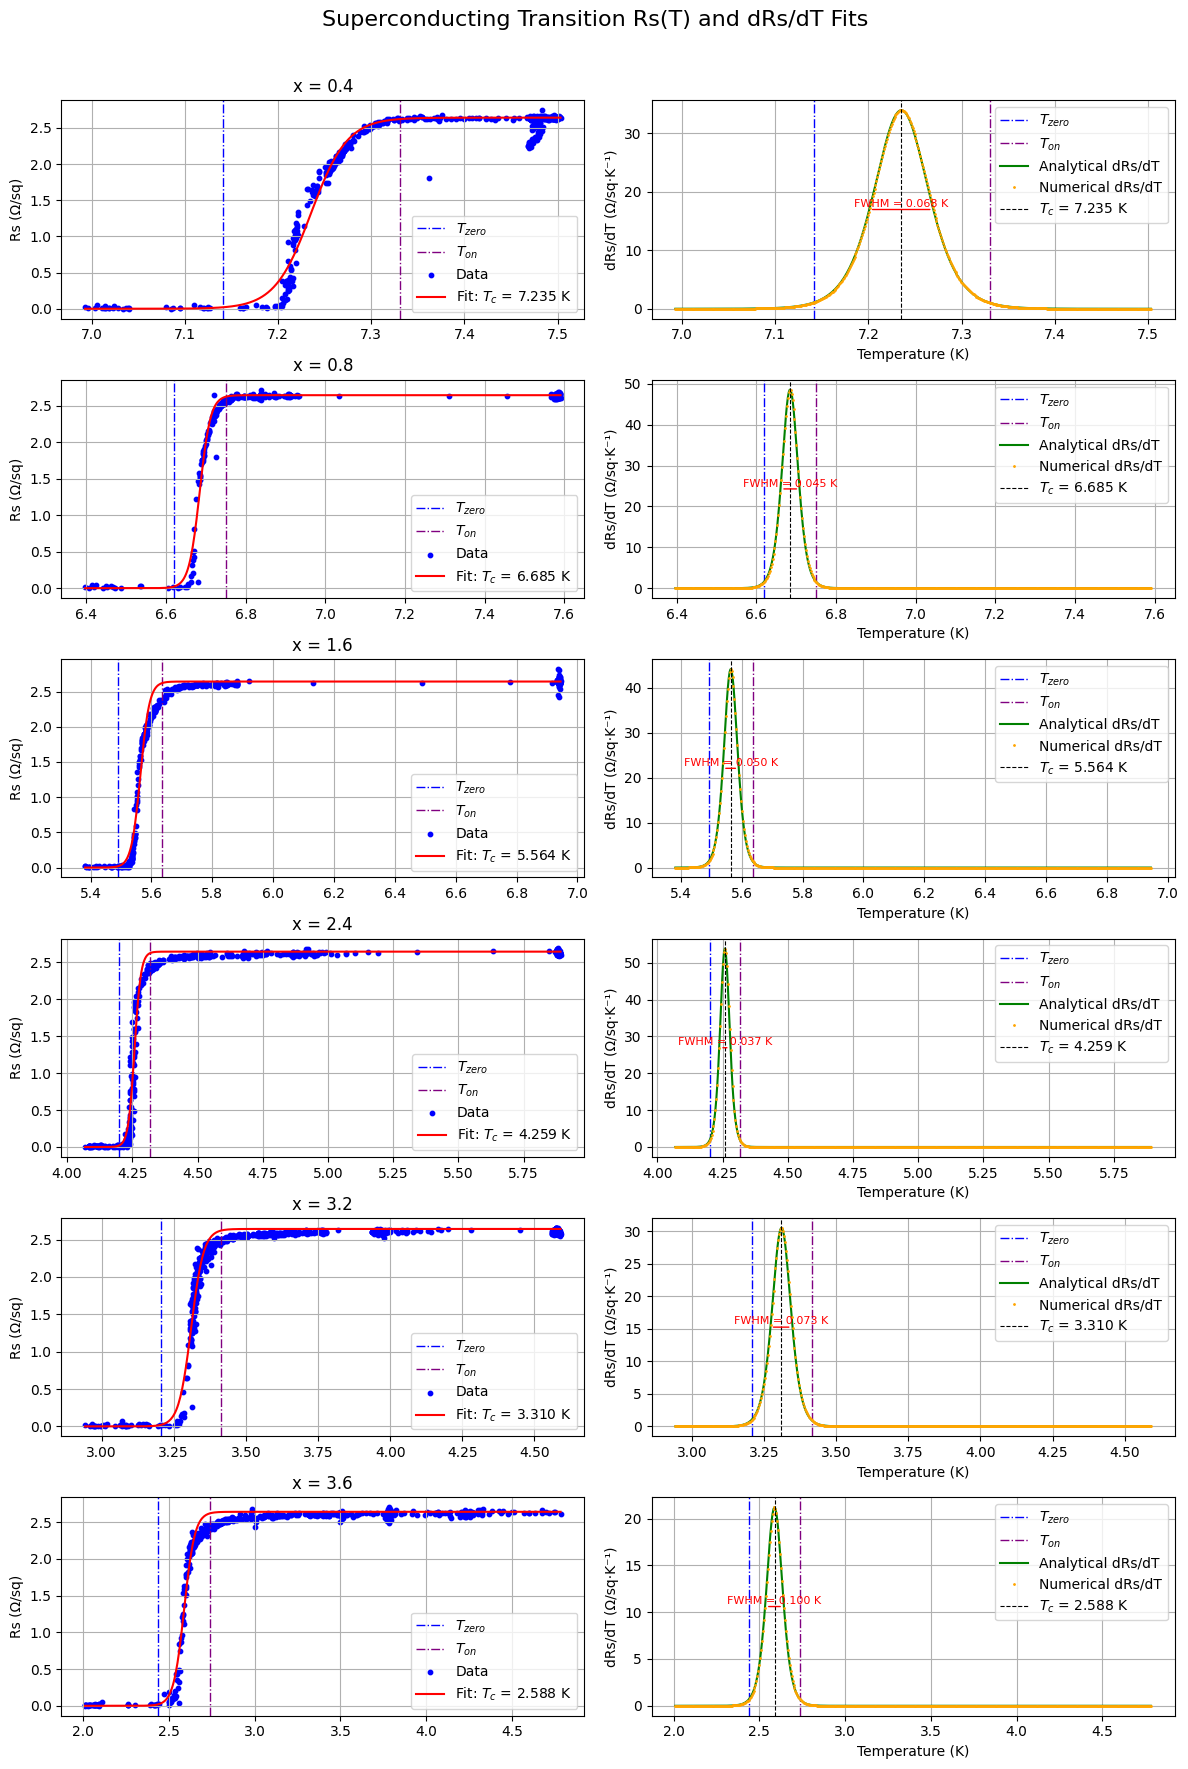

In [ ]:
Rho_0 = 2.6427

Tc_zero_val = []
Tc_on_val = []

# Fermi-Dirac like function for superconducting transition
def FD_model(T, T_c, delta_T):
    return Rho_0 / (1 + np.exp(-(T - T_c) / delta_T))

def dR_dT_FD(T, T_c, delta_T):
    exp_term = np.exp(-(T - T_c) / delta_T)
    return (Rho_0 / delta_T) * (exp_term / (1 + exp_term)**2)

# --- X values from your original dataset names ---
x_vals = [0.4, 0.8, 1.6, 2.4, 3.2, 3.6]

# --- Plotting ---
fig, axs = plt.subplots(len(x_vals), 2, figsize=(12, 3 * len(x_vals)), sharex=False)
fig.suptitle("Superconducting Transition Rs(T) and dRs/dT Fits", fontsize=16)

for i, x in enumerate(x_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    # Sort
    sorted_idx = np.argsort(Tf)
    Tf_sorted = Tf[sorted_idx]
    Rs_sorted = Rs[sorted_idx]

    # Initial guess for Tc: where -dR/dT peaks
    guess_Tc = Tf_sorted[np.argmax(np.gradient(-Rs_sorted))]
    try:
        popt, _ = curve_fit(FD_model, Tf_sorted, Rs_sorted, p0=[guess_Tc, 0.1])
        T_c_fit, delta_T_fit = popt
    except RuntimeError:
        print(f"Fit did not converge for x={x}")
        continue

    # Evaluate Rs(T) model
    Tf_fit = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 500)
    Rs_fit = FD_model(Tf_fit, *popt)

    # Numerical derivative
    dRs_numeric = np.gradient(Rs_fit, Tf_fit)

    # Remove NaNs/infs
    valid_mask = np.isfinite(dRs_numeric) & np.isfinite(Tf_fit)
    Tf_valid = Tf_fit[valid_mask]
    dRs_numeric_valid = dRs_numeric[valid_mask]

    # Fit dR/dT model (optional — or just use analytical version)
    try:
        popt_dR, _ = curve_fit(dR_dT_FD, Tf_valid, dRs_numeric_valid, p0=popt)
        dRs_fit = dR_dT_FD(Tf_valid, *popt_dR)
    except RuntimeError:
        dRs_fit = dR_dT_FD(Tf_valid, *popt)

    # --- FWHM Calculation ---
    half_max = np.max(dRs_fit) / 2
    T_fwhm = Tf_valid[dRs_fit > half_max]
    FWHM = T_fwhm.max() - T_fwhm.min() if len(T_fwhm) > 1 else np.nan

    # Threshold be the 5% of the maximum derivative
    derivative_threshold = 0.03 * np.max(dRs_fit)

    # Find all indices where the analytical derivative is above the defined threshold
    significant_derivative_indices = np.where(dRs_fit > derivative_threshold)[0]

    T_derivative_onset = np.nan
    T_derivative_completion = np.nan

    if significant_derivative_indices.size > 0:
        T_derivative_onset = Tf_fit[significant_derivative_indices[0]]
        T_derivative_completion = Tf_fit[significant_derivative_indices[-1]]
    else:
        print(f"Warning: No points found where derivative exceeds threshold {derivative_threshold}.")

    Tc_zero_val.append(T_derivative_onset)
    Tc_on_val.append(T_derivative_completion)

    # --- Plot Rs(T) ---
    ax_r = axs[i, 0]
    # You can then plot these on the dRs/dT subplot:
    ax_r.axvline(T_derivative_onset, color='blue', linestyle='-.', linewidth=1, label='$T_{zero}$')
    ax_r.axvline(T_derivative_completion, color='purple', linestyle='-.', linewidth=1, label='$T_{on}$')
    ax_r.scatter(Tf_sorted, Rs_sorted, color='blue', s=10, label="Data")
    ax_r.plot(Tf_fit, Rs_fit, color='red', label=f"Fit: $T_c$ = {T_c_fit:.3f} K")
    ax_r.set_ylabel("Rs (Ω/sq)")
    ax_r.set_title(f"x = {x}")
    ax_r.legend()
    ax_r.grid(True)

    # --- Plot dRs/dT ---
    ax_d = axs[i, 1]
    ax_d.axvline(T_derivative_onset, color='blue', linestyle='-.', linewidth=1, label='$T_{zero}$')
    ax_d.axvline(T_derivative_completion, color='purple', linestyle='-.', linewidth=1, label='$T_{on}$')

    ax_d.plot(Tf_valid, dRs_fit, label="Analytical dRs/dT", color='green')
    ax_d.plot(Tf_valid, dRs_numeric_valid, '.', label="Numerical dRs/dT", color='orange', markersize=2)


    filtered_data[f'T_{x}'] = [ T_c_fit, delta_T_fit] 

    # Draw FWHM arrow
    ax_d.annotate(
        '',
        xy=(T_fwhm.min(), half_max),
        xytext=(T_fwhm.max(), half_max),
        arrowprops=dict(arrowstyle='-', color='red', linewidth=1)
    )
    ax_d.text((T_fwhm.min() + T_fwhm.max()) / 2, half_max + 0.1, f"FWHM = {FWHM:.3f} K", 
              ha='center', va='bottom', fontsize=8, color='red')

    ax_d.axvline(T_c_fit, color='black', linestyle='--', linewidth=0.8, label=f"$T_c$ = {T_c_fit:.3f} K")
    ax_d.set_xlabel("Temperature (K)")
    ax_d.set_ylabel("dRs/dT (Ω/sq·K⁻¹)")
    ax_d.grid(True)
    ax_d.legend()

    # Print ton and tzero for each B value
    print(f"B = {x}, Tc_zero = {T_derivative_onset:.5f} K, Tc_on = {T_derivative_completion:.5f} K")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Phase Diagram

In [ ]:
def egl_model(T, Bc2_0, Tc_MF):
    T_non_zero_check = np.where(T >= Tc_MF, Tc_MF - 1e-9, T) # Small offset for T near Tc_MF
    t = T_non_zero_check / Tc_MF
    result = np.where(t < 1, Bc2_0 * (1 - t**2) / (1 + t**2), 0.0)
    return result

initial_Bc2_0_FD = np.max(B_vals) * 1.5 

initial_Tc_MF_guess_FD = Tc_vals_FD[np.argmin(B_vals)]

initial_guess_FD = [initial_Bc2_0_FD, initial_Tc_MF_guess_FD]

print(f"Initial guesses for fit: Bc2(0)={initial_Bc2_0_FD:.2f}, Tc_MF={initial_Tc_MF_guess_FD:.2f}")

try:
    popt, pcov = curve_fit(egl_model, Tc_vals_FD, B_vals, p0=initial_guess_FD, sigma=Tc_uncertainties_FD, absolute_sigma=True)

    Bc2_0_fit_FD, Tc_MF_fit_FD = popt
    
    perr = np.sqrt(np.diag(pcov))
    Bc2_0_err_FD, Tc_MF_err_FD = perr

    print(f"\nFitted EGL Parameters:")
    print(f"  Bc2(0) = {Bc2_0_fit_FD:.4f} +/- {Bc2_0_err_FD:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_fit_FD:.4f} +/- {Tc_MF_err_FD:.4f} K")

    T_fit_curve = np.linspace(0, Tc_MF_fit_FD, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, Bc2_0_fit_FD, Tc_MF_fit_FD)

except RuntimeError as e:
    print(f"Error: Could not fit the EGL model. {e}")
    Bc2_0_fit_FD, Tc_MF_fit_FD = initial_guess_FD # Use initial guess for plotting if fit fails
    T_fit_curve = np.linspace(0, initial_Tc_MF_guess_FD * 1.1, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, initial_Bc2_0_FD, initial_Tc_MF_guess_FD)
    perr = [np.nan, np.nan] # Indicate errors are not available

# --- Plotting the Data and Fit ---
plt.figure(figsize=(8, 6))

# Plot experimental data with error bars
plt.errorbar(Tc_vals_FD, B_vals, yerr=Tc_uncertainties_FD, fmt='o', color='blue', capsize=4, label="Experimental $B_{c2}(T)$ Data")

# Plot the fitted EGL curve
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='-', linewidth=2,
         label=f"EGL Fit: $B_{{c2}}(0)$={Bc2_0_fit_FD:.2f} T, $T_c^{{MF}}$={Tc_MF_fit_FD:.2f} K")

# Add a dashed line for the fitted Tc_MF
plt.axvline(x=Tc_MF_fit_FD, color='gray', linestyle='--', alpha=0.7, label=f"Fitted $T_c^{{MF}}$ ({Tc_MF_fit_FD:.2f} K)")
plt.axhline(y=Bc2_0_fit_FD, color='gray', linestyle=':', alpha=0.7, label=f"Fitted $B_{{c2}}(0)$ ({Bc2_0_fit_FD:.2f} T)")

plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature Fit")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) 
plt.xlim(left=0) 
plt.tight_layout()
plt.show()

Initial guesses for fit: Bc2(0)=5.40, Tc_MF=7.24


ValueError: `sigma` has incorrect shape.

Initial guesses (T001): Bc2(0)=5.40, Tc_MF=7.14
Fitted Parameters (T001):
  Bc2(0) = 4.3870 +/- 0.0599 T
  Tc^MF  = 7.9178 +/- 0.0749 K
Initial guesses (T099): Bc2(0)=5.40, Tc_MF=7.33
Fitted Parameters (T099):
  Bc2(0) = 4.5379 +/- 0.0706 T
  Tc^MF  = 8.0379 +/- 0.0826 K


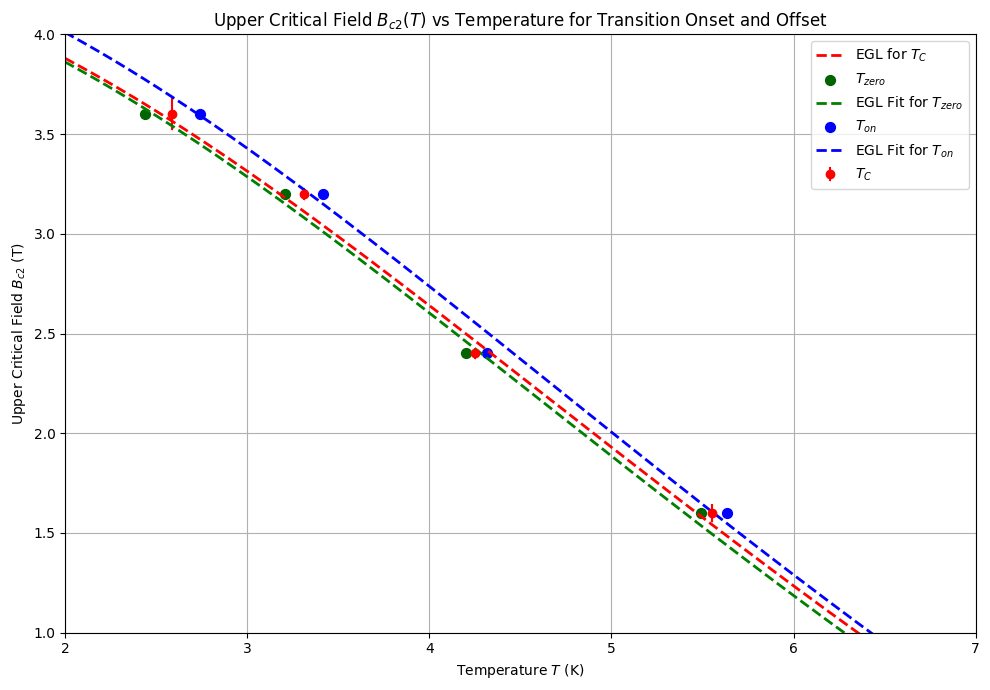

  Tc^MF (Transition Begins, T001): 7.9178 +/- 0.0749 K
  Tc^MF (Transition Ends, T099):   8.0379 +/- 0.0826 K


In [ ]:
# ---------------------- Fit for Tc_zero_val (Beginning of Transition) ----------------------

# Initial Guesses for Tc_zero_val fit
# Bc2_0_guess: Max B_val, slightly extended
initial_Bc2_0_guess_zero_FD = np.max(B_vals) * 1.5
# Tc_MF_guess: T001_val at B=0
initial_Tc_MF_guess_zero_FD = Tc_zero_val[np.argmin(B_vals)]

initial_guess_zero_FD = [initial_Bc2_0_guess_zero_FD, initial_Tc_MF_guess_zero_FD]
print(f"Initial guesses (T001): Bc2(0)={initial_Bc2_0_guess_zero_FD:.2f}, Tc_MF={initial_Tc_MF_guess_zero_FD:.2f}")

try:
    popt_zero_FD, pcov_zero_FD = curve_fit(egl_model, Tc_zero_val, B_vals, p0=initial_guess_zero_FD)
    Bc2_0_zero_fit_FD, Tc_MF_zero_fit_FD = popt_zero_FD
    perr_zero_FD = np.sqrt(np.diag(pcov_zero_FD))
    Bc2_0_zero_err_FD, Tc_MF_zero_err_FD = perr_zero_FD

    print(f"Fitted Parameters (T001):")
    print(f"  Bc2(0) = {Bc2_0_zero_fit_FD:.4f} +/- {Bc2_0_zero_err_FD:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_zero_fit_FD:.4f} +/- {Tc_MF_zero_err_FD:.4f} K")

except RuntimeError as e:
    print(f"Error fitting Tc_zero_val: {e}")
    Bc2_0_zero_fit_FD, Tc_MF_zero_fit_FD = initial_guess_zero_FD
    perr_zero_FD = [np.nan, np.nan] # Indicate errors are not available

# ------------------- Fit for Tc_on_val (End of Transition) -------------------

# Initial Guesses for Tc_on_val fit
# Bc2_0_guess: Same logic as T001
initial_Bc2_0_guess_on_FD = np.max(B_vals) * 1.5
# Tc_MF_guess: T099_val at B=0
initial_Tc_MF_guess_on_FD = Tc_on_val[np.argmin(B_vals)]

initial_guess_on_FD = [initial_Bc2_0_guess_on_FD, initial_Tc_MF_guess_on_FD]
print(f"Initial guesses (T099): Bc2(0)={initial_Bc2_0_guess_on_FD:.2f}, Tc_MF={initial_Tc_MF_guess_on_FD:.2f}")

try:
    popt_on_FD, pcov_on_FD = curve_fit(egl_model, Tc_on_val, B_vals, p0=initial_guess_on_FD)
    Bc2_0_on_fit_FD, Tc_MF_on_fit_FD = popt_on_FD
    perr_on_FD = np.sqrt(np.diag(pcov_on_FD))
    Bc2_0_on_err, Tc_MF_on_err = perr_on_FD

    print(f"Fitted Parameters (T099):")
    print(f"  Bc2(0) = {Bc2_0_on_fit_FD:.4f} +/- {Bc2_0_on_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_on_fit_FD:.4f} +/- {Tc_MF_on_err:.4f} K")

except RuntimeError as e:
    print(f"Error fitting Tc_on_val: {e}")
    Bc2_0_on_fit_FD, Tc_MF_on_fit_FD = initial_guess_on_FD
    perr_on_FD = [np.nan, np.nan] # Indicate errors are not available

# ------------------ Plotting the Data and Fits -------------------
T_fine_plot_zero = np.linspace(0, max(Tc_MF_zero_fit_FD, initial_Tc_MF_guess_zero_FD), 200)
Bc2_fit_curve_zero = egl_model(T_fine_plot_zero, Bc2_0_zero_fit_FD, Tc_MF_zero_fit_FD)

T_fine_plot_on = np.linspace(0, max(Tc_MF_on_fit_FD, initial_Tc_MF_guess_on_FD), 200)
Bc2_fit_curve_on = egl_model(T_fine_plot_on, Bc2_0_on_fit_FD, Tc_MF_on_fit_FD)

plt.figure(figsize=(10, 7))

#PLOT TC
plt.errorbar(Tc_vals, B_vals, yerr=Tc_uncertainties, fmt='o', color='red', capsize=.1, label="$T_C$")
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='--', linewidth=2,
         label="EGL for $T_C$")

# Plot TZERO
plt.scatter(Tc_zero_val, B_vals, color='darkgreen', s=50, label="$T_{zero}$")
plt.plot(T_fine_plot_zero, Bc2_fit_curve_zero, color='green', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{zero}$")

# Plot TON
plt.scatter(Tc_on_val, B_vals, color='blue', s=50, label="$T_{on}$")
plt.plot(T_fine_plot_on, Bc2_fit_curve_on, color='blue', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{on}$")

plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature for Transition Onset and Offset")
plt.legend()
plt.grid(True)
plt.ylim(bottom=1)
plt.ylim(top=4)
plt.xlim(left=2)
plt.xlim(right=7)
plt.tight_layout()
plt.show()

print(f"  Tc^MF (Transition Begins, T001): {Tc_MF_zero_fit_FD:.4f} +/- {Tc_MF_zero_err_FD:.4f} K")
print(f"  Tc^MF (Transition Ends, T099):   {Tc_MF_on_fit_FD:.4f} +/- {Tc_MF_on_err:.4f} K")

### Coherence Length

In [ ]:
PHI_0 = 2.067833848e-15 # Tesla * meter^2 (CODATA 2018 recommended value)

# --- Your given Bc2(0) value and its uncertainty ---
Bc2_0_val_FD = 4.3953
Bc2_0_err_FD = 0.0360 

xsi_0_central_FD = np.sqrt(PHI_0 / (2 * np.pi * Bc2_0_val_FD))
print(f"Central value of xsi(0): {xsi_0_central_FD:.4e} meters ({xsi_0_central_FD * 1e9:.2f} nm)")

xsi_0_uncertainty_FD = 0.5 * np.sqrt(PHI_0 / (2 * np.pi * Bc2_0_val_FD**3)) * np.abs(Bc2_0_err_FD)

print(f"xsi(0) Uncertainty: {xsi_0_uncertainty_FD:.4e} meters ({xsi_0_uncertainty_FD * 1e9:.2f} nm)")

print(f"xsi(0) = {xsi_0_central_FD:.4e} +/- {xsi_0_uncertainty_FD:.4e} T")

Central value of xsi(0): 8.6531e-09 meters (8.65 nm)
xsi(0) Uncertainty: 3.5437e-11 meters (0.04 nm)
xsi(0) = 8.6531e-09 +/- 3.5437e-11 T
